
Building the foundation for resilient agent systems with comprehensive
error handling, recovery mechanisms, and fault tolerance.

What you'll learn:

• Error classification and severity assessment

• Recovery strategy patterns

• Circuit breaker and retry mechanisms  

• Health monitoring and system diagnostics

• Graceful degradation strategies


In [1]:
import uuid
import time
import asyncio
import logging
import traceback
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Tuple, Callable, Union
from enum import Enum
from collections import defaultdict, deque
from abc import ABC, abstractmethod
import threading
from contextlib import contextmanager

In [2]:
print("Tutorial 13 Part 1: Error Handling Foundation Framework")
print("=" * 55)
print("Building resilient systems with comprehensive error handling...")
print()

Tutorial 13 Part 1: Error Handling Foundation Framework
Building resilient systems with comprehensive error handling...



In [3]:
# CORE ERROR HANDLING TYPES AND CONCEPTS
# =============================================================================

class ErrorSeverity(Enum):
    """Classification of error severity levels"""
    LOW = "low"                    # Minor issues, system continues normally
    MEDIUM = "medium"              # Notable issues, some degradation
    HIGH = "high"                  # Serious issues, significant impact
    CRITICAL = "critical"          # System-threatening, immediate action needed
    FATAL = "fatal"               # Unrecoverable, system shutdown required

class ErrorCategory(Enum):
    """Categories of errors for different handling strategies"""
    TRANSIENT = "transient"       # Temporary issues that may resolve
    PERSISTENT = "persistent"     # Ongoing issues requiring intervention
    CONFIGURATION = "configuration" # Setup or config-related errors
    RESOURCE = "resource"         # Memory, CPU, network resource issues
    DATA = "data"                 # Data validation or corruption issues
    COMMUNICATION = "communication" # Network or inter-service communication
    LOGIC = "logic"               # Business logic or algorithm errors
    EXTERNAL = "external"         # Third-party service or dependency issues

class RecoveryStrategy(Enum):
    """Different recovery approaches for different error types"""
    RETRY = "retry"               # Attempt operation again
    FALLBACK = "fallback"         # Use alternative approach
    CIRCUIT_BREAK = "circuit_break" # Temporarily disable failing component
    GRACEFUL_DEGRADE = "graceful_degrade" # Reduce functionality but continue
    ESCALATE = "escalate"         # Pass to higher-level handler
    RESTART = "restart"           # Restart component or subsystem
    IGNORE = "ignore"             # Log but continue (for non-critical errors)

@dataclass
class ErrorContext:
    """
    Rich context information about an error occurrence

    This captures everything needed to understand, classify,
    and recover from an error situation.
    """
    error_id: str = field(default_factory=lambda: str(uuid.uuid4()))
    timestamp: float = field(default_factory=time.time)

    # Error details
    error_type: str = ""
    error_message: str = ""
    stack_trace: str = ""
    severity: ErrorSeverity = ErrorSeverity.MEDIUM
    category: ErrorCategory = ErrorCategory.LOGIC

    # Context information
    component_id: str = ""
    operation_name: str = ""
    operation_args: Dict[str, Any] = field(default_factory=dict)
    system_state: Dict[str, Any] = field(default_factory=dict)

    # Recovery information
    recovery_strategy: Optional[RecoveryStrategy] = None
    retry_count: int = 0
    max_retries: int = 3
    recovery_attempted: bool = False
    recovery_successful: bool = False

    # Additional metadata
    tags: List[str] = field(default_factory=list)
    related_errors: List[str] = field(default_factory=list)
    user_impact: str = ""

    def get_age(self) -> float:
        """Get error age in seconds"""
        return time.time() - self.timestamp

    def is_retryable(self) -> bool:
        """Check if this error can be retried"""
        return (self.retry_count < self.max_retries and
                self.category in [ErrorCategory.TRANSIENT, ErrorCategory.COMMUNICATION])

    def add_related_error(self, other_error_id: str):
        """Add reference to related error"""
        if other_error_id not in self.related_errors:
            self.related_errors.append(other_error_id)

@dataclass
class RecoveryAction:
    """
    Represents a specific recovery action that can be taken

    This encapsulates both the action to take and the conditions
    under which it should be applied.
    """
    action_id: str
    strategy: RecoveryStrategy
    description: str

    # Execution details
    action_func: Callable[[ErrorContext], bool]
    conditions: List[Callable[[ErrorContext], bool]] = field(default_factory=list)

    # Timing and retry configuration
    delay_seconds: float = 0.0
    max_attempts: int = 1
    timeout_seconds: float = 30.0

    # Success criteria
    success_indicators: List[Callable[[], bool]] = field(default_factory=list)

    # Metadata
    priority: int = 50  # Higher numbers = higher priority
    tags: List[str] = field(default_factory=list)

    def can_handle(self, error_context: ErrorContext) -> bool:
        """Check if this action can handle the given error"""
        return all(condition(error_context) for condition in self.conditions)

    def execute(self, error_context: ErrorContext) -> bool:
        """Execute the recovery action"""
        try:
            if self.delay_seconds > 0:
                time.sleep(self.delay_seconds)

            success = self.action_func(error_context)

            # Check success indicators if provided
            if success and self.success_indicators:
                success = all(indicator() for indicator in self.success_indicators)

            return success
        except Exception as e:
            print(f"   ⚠️ Recovery action {self.action_id} failed: {e}")
            return False

class CircuitBreaker:
    """
    Circuit breaker pattern implementation for preventing cascade failures

    This monitors failure rates and temporarily disables failing components
    to prevent system overload and allow recovery time.
    """

    def __init__(self, failure_threshold: int = 5, recovery_timeout: float = 60.0,
                 success_threshold: int = 3):
        self.failure_threshold = failure_threshold
        self.recovery_timeout = recovery_timeout
        self.success_threshold = success_threshold

        # State tracking
        self.failure_count = 0
        self.success_count = 0
        self.last_failure_time = 0.0
        self.state = "closed"  # closed, open, half-open

        print(f"🔌 Circuit breaker initialized (threshold: {failure_threshold}, timeout: {recovery_timeout}s)")

    def call(self, func: Callable, *args, **kwargs) -> Any:
        """Execute function through circuit breaker"""

        if self.state == "open":
            if time.time() - self.last_failure_time > self.recovery_timeout:
                self.state = "half-open"
                self.success_count = 0
                print(f"   🔄 Circuit breaker moving to half-open state")
            else:
                raise Exception("Circuit breaker is open - operation blocked")

        try:
            result = func(*args, **kwargs)
            self._on_success()
            return result
        except Exception as e:
            self._on_failure()
            raise e

    def _on_success(self):
        """Handle successful operation"""
        if self.state == "half-open":
            self.success_count += 1
            if self.success_count >= self.success_threshold:
                self.state = "closed"
                self.failure_count = 0
                print(f"   ✅ Circuit breaker closed - normal operation resumed")
        elif self.state == "closed":
            self.failure_count = max(0, self.failure_count - 1)

    def _on_failure(self):
        """Handle failed operation"""
        self.failure_count += 1
        self.last_failure_time = time.time()

        if self.failure_count >= self.failure_threshold:
            self.state = "open"
            print(f"   🚨 Circuit breaker opened - {self.failure_count} failures detected")

    def get_status(self) -> Dict[str, Any]:
        """Get current circuit breaker status"""
        return {
            "state": self.state,
            "failure_count": self.failure_count,
            "success_count": self.success_count,
            "time_since_last_failure": time.time() - self.last_failure_time if self.last_failure_time > 0 else 0
        }

class HealthMonitor:
    """
    System health monitoring and diagnostics

    This tracks system health metrics and provides early warning
    of potential issues before they become critical failures.
    """

    def __init__(self):
        self.metrics = defaultdict(deque)
        self.health_checks = {}
        self.alert_thresholds = {}
        self.last_check_time = 0.0

        print("💚 Health monitor initialized")

    def register_health_check(self, name: str, check_func: Callable[[], bool],
                            interval: float = 30.0):
        """Register a health check function"""
        self.health_checks[name] = {
            'function': check_func,
            'interval': interval,
            'last_run': 0.0,
            'last_result': None,
            'failure_count': 0
        }
        print(f"   📋 Registered health check: {name} (interval: {interval}s)")

    def add_metric(self, name: str, value: float):
        """Add a metric value"""
        self.metrics[name].append((time.time(), value))

        # Keep only recent values (last hour)
        cutoff_time = time.time() - 3600
        while self.metrics[name] and self.metrics[name][0][0] < cutoff_time:
            self.metrics[name].popleft()

    def set_alert_threshold(self, metric_name: str, threshold: float, operator: str = "greater"):
        """Set alert threshold for a metric"""
        self.alert_thresholds[metric_name] = {
            'threshold': threshold,
            'operator': operator
        }
        print(f"   🚨 Alert threshold set: {metric_name} {operator} {threshold}")

    def check_health(self) -> Dict[str, Any]:
        """Perform all health checks and return status"""
        current_time = time.time()

        health_status = {
            'overall_status': 'healthy',
            'checks': {},
            'metrics': {},
            'alerts': []
        }

        # Run health checks
        for name, check_info in self.health_checks.items():
            if current_time - check_info['last_run'] >= check_info['interval']:
                try:
                    result = check_info['function']()
                    check_info['last_result'] = result
                    check_info['last_run'] = current_time

                    if not result:
                        check_info['failure_count'] += 1
                    else:
                        check_info['failure_count'] = 0

                except Exception as e:
                    result = False
                    check_info['failure_count'] += 1
                    print(f"   ⚠️ Health check {name} failed: {e}")

            health_status['checks'][name] = {
                'status': 'pass' if check_info.get('last_result', True) else 'fail',
                'failure_count': check_info['failure_count'],
                'last_run': check_info['last_run']
            }

            if check_info['failure_count'] > 3:
                health_status['overall_status'] = 'unhealthy'

        # Check metric thresholds
        for metric_name, threshold_info in self.alert_thresholds.items():
            if metric_name in self.metrics and self.metrics[metric_name]:
                latest_value = self.metrics[metric_name][-1][1]
                threshold = threshold_info['threshold']
                operator = threshold_info['operator']

                alert_triggered = False
                if operator == "greater" and latest_value > threshold:
                    alert_triggered = True
                elif operator == "less" and latest_value < threshold:
                    alert_triggered = True

                if alert_triggered:
                    health_status['alerts'].append({
                        'metric': metric_name,
                        'value': latest_value,
                        'threshold': threshold,
                        'operator': operator
                    })
                    health_status['overall_status'] = 'warning'

        # Add metric summaries
        for metric_name, values in self.metrics.items():
            if values:
                recent_values = [v[1] for v in list(values)[-10:]]  # Last 10 values
                health_status['metrics'][metric_name] = {
                    'latest': recent_values[-1],
                    'average': sum(recent_values) / len(recent_values),
                    'min': min(recent_values),
                    'max': max(recent_values),
                    'count': len(values)
                }

        return health_status

# =============================================================================
# TEST THE FOUNDATION CLASSES
# =============================================================================

print("🧪 Testing Error Handling Foundation...")
print()

# Test ErrorContext
print("📋 Testing ErrorContext:")
error_context = ErrorContext(
    error_type="ConnectionError",
    error_message="Failed to connect to database",
    severity=ErrorSeverity.HIGH,
    category=ErrorCategory.COMMUNICATION,
    component_id="database_client",
    operation_name="execute_query",
    operation_args={"query": "SELECT * FROM users", "timeout": 30},
    system_state={"cpu_usage": 0.8, "memory_usage": 0.6}
)

print(f"   Created error: {error_context.error_id[:8]}...")
print(f"   Type: {error_context.error_type}")
print(f"   Severity: {error_context.severity.value}")
print(f"   Category: {error_context.category.value}")
print(f"   Is retryable: {error_context.is_retryable()}")
print(f"   Age: {error_context.get_age():.3f} seconds")

# Test RecoveryAction
print(f"\n🔧 Testing RecoveryAction:")

def retry_connection(error_ctx: ErrorContext) -> bool:
    """Mock recovery function"""
    print(f"   🔄 Attempting to retry connection for {error_ctx.component_id}")
    # Simulate 70% success rate
    import random
    success = random.random() > 0.3
    if success:
        print(f"   ✅ Connection retry successful")
    else:
        print(f"   ❌ Connection retry failed")
    return success

def is_connection_error(error_ctx: ErrorContext) -> bool:
    """Check if this is a connection error"""
    return "connection" in error_ctx.error_type.lower()

retry_action = RecoveryAction(
    action_id="connection_retry",
    strategy=RecoveryStrategy.RETRY,
    description="Retry database connection",
    action_func=retry_connection,
    conditions=[is_connection_error],
    delay_seconds=1.0,
    max_attempts=3
)

print(f"   Created recovery action: {retry_action.action_id}")
print(f"   Strategy: {retry_action.strategy.value}")
print(f"   Can handle error: {retry_action.can_handle(error_context)}")

# Execute recovery action
if retry_action.can_handle(error_context):
    print(f"   Executing recovery action...")
    success = retry_action.execute(error_context)
    print(f"   Recovery result: {'✅ Success' if success else '❌ Failed'}")

# Test CircuitBreaker
print(f"\n🔌 Testing CircuitBreaker:")

def unreliable_function():
    """Simulate an unreliable function for testing"""
    import random
    if random.random() < 0.7:  # 70% failure rate
        raise Exception("Simulated failure")
    return "Success!"

circuit_breaker = CircuitBreaker(failure_threshold=3, recovery_timeout=5.0)

print(f"   Testing circuit breaker with unreliable function...")
for i in range(8):
    try:
        result = circuit_breaker.call(unreliable_function)
        print(f"   Attempt {i+1}: ✅ {result}")
    except Exception as e:
        print(f"   Attempt {i+1}: ❌ {str(e)}")

    if i == 4:  # Check status mid-way
        status = circuit_breaker.get_status()
        print(f"   Circuit breaker status: {status['state']} (failures: {status['failure_count']})")

# Test HealthMonitor
print(f"\n💚 Testing HealthMonitor:")

health_monitor = HealthMonitor()

# Register some health checks
def check_memory_usage() -> bool:
    """Mock memory usage check"""
    import random
    usage = random.uniform(0.3, 0.9)
    health_monitor.add_metric("memory_usage", usage)
    return usage < 0.8

def check_database_connection() -> bool:
    """Mock database connection check"""
    import random
    connected = random.random() > 0.1  # 90% success rate
    return connected

health_monitor.register_health_check("memory_check", check_memory_usage, interval=5.0)
health_monitor.register_health_check("database_check", check_database_connection, interval=10.0)

# Set alert thresholds
health_monitor.set_alert_threshold("memory_usage", 0.75, "greater")

# Add some test metrics
for i in range(5):
    health_monitor.add_metric("cpu_usage", 0.4 + i * 0.1)
    health_monitor.add_metric("response_time", 100 + i * 50)

# Perform health check
print(f"   Performing comprehensive health check...")
health_status = health_monitor.check_health()

print(f"   Overall status: {health_status['overall_status']}")
print(f"   Health checks:")
for name, status in health_status['checks'].items():
    status_icon = "✅" if status['status'] == 'pass' else "❌"
    print(f"     {name}: {status_icon} {status['status']} (failures: {status['failure_count']})")

print(f"   Metrics summary:")
for name, metrics in health_status['metrics'].items():
    print(f"     {name}: latest={metrics['latest']:.3f}, avg={metrics['average']:.3f}")

if health_status['alerts']:
    print(f"   🚨 Active alerts:")
    for alert in health_status['alerts']:
        print(f"     {alert['metric']}: {alert['value']:.3f} {alert['operator']} {alert['threshold']}")

print()
print("🎉 Error Handling Foundation working correctly!")
print("   Ready for Part 2: Error Recovery Engine")
print()
print("📋 Summary of what we built:")
print("   • ErrorContext - Rich error information with classification")
print("   • RecoveryAction - Executable recovery strategies")
print("   • CircuitBreaker - Cascade failure prevention")
print("   • HealthMonitor - Proactive system health tracking")
print("   • Error severity and category classification")
print("   • Recovery strategy patterns")
print("   • Comprehensive system diagnostics")

🧪 Testing Error Handling Foundation...

📋 Testing ErrorContext:
   Created error: 3228a757...
   Type: ConnectionError
   Severity: high
   Category: communication
   Is retryable: True
   Age: 0.000 seconds

🔧 Testing RecoveryAction:
   Created recovery action: connection_retry
   Strategy: retry
   Can handle error: True
   Executing recovery action...
   🔄 Attempting to retry connection for database_client
   ✅ Connection retry successful
   Recovery result: ✅ Success

🔌 Testing CircuitBreaker:
🔌 Circuit breaker initialized (threshold: 3, timeout: 5.0s)
   Testing circuit breaker with unreliable function...
   Attempt 1: ❌ Simulated failure
   Attempt 2: ❌ Simulated failure
   🚨 Circuit breaker opened - 3 failures detected
   Attempt 3: ❌ Simulated failure
   Attempt 4: ❌ Circuit breaker is open - operation blocked
   Attempt 5: ❌ Circuit breaker is open - operation blocked
   Circuit breaker status: open (failures: 3)
   Attempt 6: ❌ Circuit breaker is open - operation blocked
   A

In [21]:

"""
Tutorial 13 Part 2: Error Recovery Engine
========================================

Building a sophisticated error recovery engine that automatically
handles failures, implements recovery strategies, and maintains
system resilience through intelligent error processing.

This part builds on the foundation from Part 1.
"""

import asyncio
import threading
from concurrent.futures import ThreadPoolExecutor, TimeoutError
from typing import Dict, List, Optional, Callable, Any
import time
import uuid
from collections import defaultdict, deque
from dataclasses import dataclass, field

# Import foundation classes from Part 1
# (In practice, these would be imported from the previous module)

print("Tutorial 13 Part 2: Error Recovery Engine")
print("=" * 42)
print("Building intelligent error recovery and resilience systems...")
print()

class ErrorRecoveryEngine:
    """
    Central engine for error recovery and system resilience

    This coordinates error detection, classification, recovery strategy
    selection, and execution across the entire system.
    """

    def __init__(self, max_concurrent_recoveries: int = 5):
        self.max_concurrent_recoveries = max_concurrent_recoveries

        # Error and recovery tracking
        self.active_errors = {}  # error_id -> ErrorContext
        self.recovery_actions = {}  # strategy -> List[RecoveryAction]
        self.recovery_history = deque(maxlen=1000)

        # Recovery execution
        self.recovery_executor = ThreadPoolExecutor(max_workers=max_concurrent_recoveries)
        self.active_recoveries = {}  # error_id -> Future

        # Circuit breakers for different components
        self.circuit_breakers = {}  # component_id -> CircuitBreaker

        # Health monitoring
        self.health_monitor = HealthMonitor()

        # Statistics
        self.recovery_stats = defaultdict(int)
        self.error_patterns = defaultdict(list)

        # Configuration
        self.auto_recovery_enabled = True
        self.max_recovery_attempts = 3
        self.recovery_cooldown = 30.0  # seconds between recovery attempts

        print(f"🔧 Error Recovery Engine initialized")
        print(f"   Max concurrent recoveries: {max_concurrent_recoveries}")
        print(f"   Auto-recovery: {'enabled' if self.auto_recovery_enabled else 'disabled'}")

    def register_recovery_action(self, action: RecoveryAction):
        """Register a recovery action for a specific strategy"""
        if action.strategy not in self.recovery_actions:
            self.recovery_actions[action.strategy] = []

        self.recovery_actions[action.strategy].append(action)

        # Sort by priority (highest first)
        self.recovery_actions[action.strategy].sort(key=lambda a: a.priority, reverse=True)

        print(f"   ➕ Registered recovery action: {action.action_id} for {action.strategy.value}")

    def register_circuit_breaker(self, component_id: str, circuit_breaker: CircuitBreaker):
        """Register a circuit breaker for a component"""
        self.circuit_breakers[component_id] = circuit_breaker
        print(f"   🔌 Registered circuit breaker for: {component_id}")

    def handle_error(self, error_context: ErrorContext) -> str:
        """
        Main entry point for error handling

        This processes an error, determines the appropriate recovery
        strategy, and initiates recovery if appropriate.
        """

        print(f"🚨 Handling error: {error_context.error_type}")
        print(f"   Error ID: {error_context.error_id[:8]}...")
        print(f"   Severity: {error_context.severity.value}")
        print(f"   Component: {error_context.component_id}")

        # Store the error
        self.active_errors[error_context.error_id] = error_context

        # Update error patterns for analysis
        pattern_key = f"{error_context.component_id}:{error_context.error_type}"
        self.error_patterns[pattern_key].append(time.time())

        # Check for error frequency patterns
        self._analyze_error_patterns(pattern_key)

        # Determine recovery strategy
        recovery_strategy = self._determine_recovery_strategy(error_context)
        error_context.recovery_strategy = recovery_strategy

        print(f"   🎯 Selected recovery strategy: {recovery_strategy.value}")

        # Execute recovery if auto-recovery is enabled
        if self.auto_recovery_enabled:
            recovery_id = self._initiate_recovery(error_context)
            print(f"   🔄 Initiated recovery: {recovery_id[:8]}...")
            return recovery_id

        return error_context.error_id

    def _determine_recovery_strategy(self, error_context: ErrorContext) -> RecoveryStrategy:
        """
        Intelligent recovery strategy selection

        This analyzes the error context and system state to determine
        the most appropriate recovery approach.
        """

        # Check circuit breaker state for this component
        if error_context.component_id in self.circuit_breakers:
            breaker = self.circuit_breakers[error_context.component_id]
            if breaker.state == "open":
                return RecoveryStrategy.CIRCUIT_BREAK

        # Strategy selection based on error characteristics
        if error_context.severity == ErrorSeverity.FATAL:
            return RecoveryStrategy.RESTART

        if error_context.severity == ErrorSeverity.CRITICAL:
            if error_context.category == ErrorCategory.RESOURCE:
                return RecoveryStrategy.GRACEFUL_DEGRADE
            else:
                return RecoveryStrategy.ESCALATE

        if error_context.category == ErrorCategory.TRANSIENT:
            if error_context.is_retryable():
                return RecoveryStrategy.RETRY
            else:
                return RecoveryStrategy.FALLBACK

        if error_context.category == ErrorCategory.COMMUNICATION:
            return RecoveryStrategy.RETRY

        if error_context.category == ErrorCategory.CONFIGURATION:
            return RecoveryStrategy.ESCALATE

        if error_context.severity == ErrorSeverity.LOW:
            return RecoveryStrategy.IGNORE

        # Default fallback strategy
        return RecoveryStrategy.FALLBACK

    def _analyze_error_patterns(self, pattern_key: str):
        """Analyze error patterns to detect recurring issues"""

        error_times = self.error_patterns[pattern_key]

        # Keep only recent errors (last 5 minutes)
        cutoff_time = time.time() - 300
        recent_errors = [t for t in error_times if t > cutoff_time]
        self.error_patterns[pattern_key] = recent_errors

        # Check for error spikes
        if len(recent_errors) > 5:
            print(f"   ⚠️ Error spike detected for {pattern_key}: {len(recent_errors)} errors in 5 minutes")

            # If we have a circuit breaker for this component, trigger it
            component_id = pattern_key.split(':')[0]
            if component_id in self.circuit_breakers:
                breaker = self.circuit_breakers[component_id]
                breaker._on_failure()  # Force circuit breaker evaluation

    def _initiate_recovery(self, error_context: ErrorContext) -> str:
        """
        Initiate recovery process for an error

        This selects and executes appropriate recovery actions
        based on the determined strategy.
        """

        recovery_id = str(uuid.uuid4())

        # Check if we're already at max concurrent recoveries
        if len(self.active_recoveries) >= self.max_concurrent_recoveries:
            print(f"   ⏳ Recovery queued - max concurrent recoveries reached")
            # In a real system, you might queue this for later
            return recovery_id

        # Find suitable recovery actions
        strategy = error_context.recovery_strategy
        suitable_actions = []

        if strategy in self.recovery_actions:
            for action in self.recovery_actions[strategy]:
                if action.can_handle(error_context):
                    suitable_actions.append(action)

        if not suitable_actions:
            print(f"   ❌ No suitable recovery actions found for {strategy.value}")
            return recovery_id

        # Select the highest priority action
        selected_action = suitable_actions[0]
        print(f"   🎯 Selected recovery action: {selected_action.action_id}")

        # Execute recovery action asynchronously
        future = self.recovery_executor.submit(
            self._execute_recovery, recovery_id, error_context, selected_action
        )

        self.active_recoveries[recovery_id] = {
            'future': future,
            'error_context': error_context,
            'action': selected_action,
            'start_time': time.time()
        }

        return recovery_id

    def _execute_recovery(self, recovery_id: str, error_context: ErrorContext,
                         action: RecoveryAction) -> bool:
        """
        Execute a specific recovery action

        This runs the recovery action and handles the results,
        including retry logic and success validation.
        """

        print(f"   🔄 Executing recovery {recovery_id[:8]}... with action {action.action_id}")

        success = False
        attempts = 0

        while attempts < action.max_attempts and not success:
            attempts += 1
            error_context.retry_count = attempts

            try:
                print(f"     Attempt {attempts}/{action.max_attempts}")
                success = action.execute(error_context)

                if success:
                    print(f"     ✅ Recovery action succeeded on attempt {attempts}")
                    error_context.recovery_successful = True
                else:
                    print(f"     ❌ Recovery action failed on attempt {attempts}")

            except Exception as e:
                print(f"     💥 Recovery action threw exception: {e}")
                success = False

            # Delay between attempts if needed
            if not success and attempts < action.max_attempts and action.delay_seconds > 0:
                time.sleep(action.delay_seconds)

        # Update recovery statistics
        strategy_key = action.strategy.value
        if success:
            self.recovery_stats[f"{strategy_key}_success"] += 1
        else:
            self.recovery_stats[f"{strategy_key}_failure"] += 1

        # Record recovery in history
        recovery_record = {
            'recovery_id': recovery_id,
            'error_id': error_context.error_id,
            'strategy': action.strategy.value,
            'action_id': action.action_id,
            'success': success,
            'attempts': attempts,
            'duration': time.time() - self.active_recoveries[recovery_id]['start_time'],
            'timestamp': time.time()
        }
        self.recovery_history.append(recovery_record)

        # Clean up active recovery tracking
        if recovery_id in self.active_recoveries:
            del self.active_recoveries[recovery_id]

        # Update error context
        error_context.recovery_attempted = True
        error_context.recovery_successful = success

        return success

    def get_recovery_status(self, recovery_id: str) -> Optional[Dict[str, Any]]:
        """Get status of an active or completed recovery"""

        # Check active recoveries
        if recovery_id in self.active_recoveries:
            recovery_info = self.active_recoveries[recovery_id]
            return {
                'status': 'in_progress',
                'error_id': recovery_info['error_context'].error_id,
                'action': recovery_info['action'].action_id,
                'duration': time.time() - recovery_info['start_time'],
                'completed': False
            }

        # Check recovery history
        for record in reversed(self.recovery_history):
            if record['recovery_id'] == recovery_id:
                return {
                    'status': 'completed',
                    'success': record['success'],
                    'attempts': record['attempts'],
                    'duration': record['duration'],
                    'completed': True
                }

        return None

    def get_system_health(self) -> Dict[str, Any]:
        """Get comprehensive system health status"""

        health_status = self.health_monitor.check_health()

        # Add recovery engine specific metrics
        active_error_count = len(self.active_errors)
        active_recovery_count = len(self.active_recoveries)

        # Calculate recovery success rate
        total_recoveries = sum(v for k, v in self.recovery_stats.items() if 'success' in k or 'failure' in k)
        successful_recoveries = sum(v for k, v in self.recovery_stats.items() if 'success' in k)

        if total_recoveries > 0:
            recovery_success_rate = successful_recoveries / total_recoveries
        else:
            recovery_success_rate = 0.0

        # Circuit breaker statuses
        circuit_breaker_status = {}
        for component_id, breaker in self.circuit_breakers.items():
            circuit_breaker_status[component_id] = breaker.get_status()

        health_status.update({
            'recovery_engine': {
                'active_errors': active_error_count,
                'active_recoveries': active_recovery_count,
                'recovery_success_rate': recovery_success_rate,
                'total_recoveries': total_recoveries,
                'auto_recovery_enabled': self.auto_recovery_enabled
            },
            'circuit_breakers': circuit_breaker_status,
            'recovery_statistics': dict(self.recovery_stats)
        })

        return health_status

    def emergency_shutdown(self, reason: str):
        """Emergency shutdown procedure for critical failures"""

        print(f"🚨 EMERGENCY SHUTDOWN INITIATED: {reason}")

        # Disable auto-recovery
        self.auto_recovery_enabled = False

        # Cancel all active recoveries
        for recovery_id, recovery_info in self.active_recoveries.items():
            recovery_info['future'].cancel()
            print(f"   ❌ Cancelled recovery: {recovery_id[:8]}...")

        self.active_recoveries.clear()

        # Open all circuit breakers
        for component_id, breaker in self.circuit_breakers.items():
            breaker.state = "open"
            breaker.failure_count = breaker.failure_threshold
            print(f"   🔌 Opened circuit breaker: {component_id}")

        # Shutdown recovery executor
        self.recovery_executor.shutdown(wait=False)

        print(f"   🛑 Emergency shutdown complete")

class GracefulDegradationManager:
    """
    Manages graceful degradation strategies

    This handles reducing system functionality while maintaining
    core operations during stress or failure conditions.
    """

    def __init__(self):
        self.degradation_strategies = {}
        self.active_degradations = {}
        self.feature_priorities = {}

        print("🎚️ Graceful Degradation Manager initialized")

    def register_degradation_strategy(self, feature_name: str, priority: int,
                                    disable_func: Callable[[], bool],
                                    enable_func: Callable[[], bool],
                                    health_check: Callable[[], bool]):
        """Register a degradation strategy for a feature"""

        self.degradation_strategies[feature_name] = {
            'priority': priority,  # Higher = more important, degrade later
            'disable_func': disable_func,
            'enable_func': enable_func,
            'health_check': health_check,
            'degraded': False
        }

        self.feature_priorities[feature_name] = priority
        print(f"   📋 Registered degradation strategy: {feature_name} (priority: {priority})")

    def trigger_degradation(self, system_load: float) -> List[str]:
        """
        Trigger degradation based on system load

        Returns list of features that were degraded.
        """

        degraded_features = []

        # Sort features by priority (lowest first - degrade these first)
        sorted_features = sorted(self.feature_priorities.items(), key=lambda x: x[1])

        degradation_threshold = 0.8  # Start degrading at 80% system load

        if system_load > degradation_threshold:
            degradation_level = (system_load - degradation_threshold) / (1.0 - degradation_threshold)
            features_to_degrade = int(degradation_level * len(sorted_features))

            print(f"   🎚️ System load {system_load:.1%} - degrading {features_to_degrade} features")

            for feature_name, _ in sorted_features[:features_to_degrade]:
                if not self.degradation_strategies[feature_name]['degraded']:
                    success = self._degrade_feature(feature_name)
                    if success:
                        degraded_features.append(feature_name)

        return degraded_features

    def _degrade_feature(self, feature_name: str) -> bool:
        """Degrade a specific feature"""

        strategy = self.degradation_strategies[feature_name]

        try:
            success = strategy['disable_func']()
            if success:
                strategy['degraded'] = True
                self.active_degradations[feature_name] = time.time()
                print(f"     ⬇️ Degraded feature: {feature_name}")
                return True
        except Exception as e:
            print(f"     ❌ Failed to degrade {feature_name}: {e}")

        return False

    def restore_features(self) -> List[str]:
        """Attempt to restore degraded features"""

        restored_features = []

        for feature_name in list(self.active_degradations.keys()):
            if self._restore_feature(feature_name):
                restored_features.append(feature_name)
                del self.active_degradations[feature_name]

        return restored_features

    def _restore_feature(self, feature_name: str) -> bool:
        """Restore a specific degraded feature"""

        strategy = self.degradation_strategies[feature_name]

        # Check if system is healthy enough to restore
        try:
            if strategy['health_check']():
                success = strategy['enable_func']()
                if success:
                    strategy['degraded'] = False
                    print(f"     ⬆️ Restored feature: {feature_name}")
                    return True
        except Exception as e:
            print(f"     ❌ Failed to restore {feature_name}: {e}")

        return False

    def get_degradation_status(self) -> Dict[str, Any]:
        """Get current degradation status"""

        return {
            'total_features': len(self.degradation_strategies),
            'degraded_features': len(self.active_degradations),
            'active_degradations': {
                name: {
                    'degraded_since': time.time() - degraded_time,
                    'priority': self.feature_priorities[name]
                }
                for name, degraded_time in self.active_degradations.items()
            },
            'available_features': [
                name for name, strategy in self.degradation_strategies.items()
                if not strategy['degraded']
            ]
        }

# =============================================================================
# COMPREHENSIVE TESTING OF RECOVERY ENGINE
# =============================================================================

print("🧪 Testing Error Recovery Engine...")
print()

# Create recovery engine
recovery_engine = ErrorRecoveryEngine(max_concurrent_recoveries=3)

# Create and register some recovery actions
print("🔧 Setting up recovery actions...")

def database_retry_action(error_ctx: ErrorContext) -> bool:
    """Mock database retry"""
    print(f"     🔄 Retrying database operation for {error_ctx.operation_name}")
    import random
    success = random.random() > 0.4  # 60% success rate
    if success:
        print(f"     ✅ Database retry successful")
    else:
        print(f"     ❌ Database retry failed")
    return success

def api_fallback_action(error_ctx: ErrorContext) -> bool:
    """Mock API fallback"""
    print(f"     🔄 Using fallback API for {error_ctx.operation_name}")
    # Fallback usually succeeds
    success = True
    print(f"     ✅ Fallback API successful")
    return success

def service_restart_action(error_ctx: ErrorContext) -> bool:
    """Mock service restart"""
    print(f"     🔄 Restarting service {error_ctx.component_id}")
    # Restart usually succeeds but takes time
    time.sleep(0.5)
    success = True
    print(f"     ✅ Service restart successful")
    return success

# Create recovery actions
db_retry = RecoveryAction(
    action_id="database_retry",
    strategy=RecoveryStrategy.RETRY,
    description="Retry database operation",
    action_func=database_retry_action,
    conditions=[lambda ctx: "database" in ctx.component_id.lower()],
    max_attempts=3,
    delay_seconds=0.5,
    priority=80
)

api_fallback = RecoveryAction(
    action_id="api_fallback",
    strategy=RecoveryStrategy.FALLBACK,
    description="Use fallback API",
    action_func=api_fallback_action,
    conditions=[lambda ctx: "api" in ctx.component_id.lower()],
    priority=70
)

service_restart = RecoveryAction(
    action_id="service_restart",
    strategy=RecoveryStrategy.RESTART,
    description="Restart failed service",
    action_func=service_restart_action,
    conditions=[lambda ctx: ctx.severity == ErrorSeverity.CRITICAL],
    priority=90
)

# Register recovery actions
recovery_engine.register_recovery_action(db_retry)
recovery_engine.register_recovery_action(api_fallback)
recovery_engine.register_recovery_action(service_restart)

# Register circuit breakers
from dataclasses import dataclass

@dataclass
class MockCircuitBreaker:
    """Mock circuit breaker for testing"""
    failure_threshold: int = 3
    state: str = "closed"
    failure_count: int = 0

    def get_status(self):
        return {
            "state": self.state,
            "failure_count": self.failure_count,
            "success_count": 0,
            "time_since_last_failure": 0
        }

    def _on_failure(self):
        self.failure_count += 1
        if self.failure_count >= self.failure_threshold:
            self.state = "open"

db_breaker = MockCircuitBreaker()
api_breaker = MockCircuitBreaker()

recovery_engine.register_circuit_breaker("database_service", db_breaker)
recovery_engine.register_circuit_breaker("api_service", api_breaker)

# Test different error scenarios
print("\n🚨 Testing error scenarios...")

# Scenario 1: Database connection error
print("\n1. Database Connection Error:")
db_error = ErrorContext(
    error_type="ConnectionTimeoutError",
    error_message="Database connection timed out after 30 seconds",
    severity=ErrorSeverity.HIGH,
    category=ErrorCategory.COMMUNICATION,
    component_id="database_service",
    operation_name="execute_query",
    operation_args={"query": "SELECT * FROM users", "timeout": 30}
)

recovery_id_1 = recovery_engine.handle_error(db_error)

# Scenario 2: API service error
print("\n2. API Service Error:")
api_error = ErrorContext(
    error_type="ServiceUnavailableError",
    error_message="External API service returned 503",
    severity=ErrorSeverity.MEDIUM,
    category=ErrorCategory.EXTERNAL,
    component_id="api_service",
    operation_name="fetch_user_data",
    operation_args={"user_id": 12345}
)

recovery_id_2 = recovery_engine.handle_error(api_error)

# Scenario 3: Critical system error
print("\n3. Critical System Error:")
critical_error = ErrorContext(
    error_type="OutOfMemoryError",
    error_message="System running out of available memory",
    severity=ErrorSeverity.CRITICAL,
    category=ErrorCategory.RESOURCE,
    component_id="main_service",
    operation_name="process_large_dataset"
)

recovery_id_3 = recovery_engine.handle_error(critical_error)

# Wait for recoveries to complete
print("\n⏳ Waiting for recoveries to complete...")
time.sleep(2)

# Check recovery statuses
print("\n📊 Recovery Status Check:")
for i, recovery_id in enumerate([recovery_id_1, recovery_id_2, recovery_id_3], 1):
    status = recovery_engine.get_recovery_status(recovery_id)
    if status:
        status_icon = "✅" if status.get('success', False) else "❌" if status.get('completed', False) else "⏳"
        print(f"   Recovery {i}: {status_icon} {status['status']}")
        if status.get('completed'):
            print(f"     Success: {status['success']}, Attempts: {status['attempts']}, Duration: {status['duration']:.2f}s")

# Test graceful degradation
print("\n🎚️ Testing Graceful Degradation...")

degradation_manager = GracefulDegradationManager()

# Mock feature control functions
features_state = {
    'analytics': True,
    'recommendations': True,
    'notifications': True,
    'caching': True
}

def disable_analytics():
    features_state['analytics'] = False
    return True

def enable_analytics():
    features_state['analytics'] = True
    return True

def check_analytics_health():
    return True  # Always healthy for demo

def disable_recommendations():
    features_state['recommendations'] = False
    return True

def enable_recommendations():
    features_state['recommendations'] = True
    return True

def check_recommendations_health():
    return True

# Register degradation strategies
degradation_manager.register_degradation_strategy(
    "analytics", priority=30,
    disable_func=disable_analytics,
    enable_func=enable_analytics,
    health_check=check_analytics_health
)

degradation_manager.register_degradation_strategy(
    "recommendations", priority=50,
    disable_func=disable_recommendations,
    enable_func=enable_recommendations,
    health_check=check_recommendations_health
)

# Simulate high system load
print("   Simulating high system load (90%)...")
degraded = degradation_manager.trigger_degradation(0.9)
print(f"   Degraded features: {degraded}")

# Show degradation status
status = degradation_manager.get_degradation_status()
print(f"   Total features: {status['total_features']}")
print(f"   Degraded features: {status['degraded_features']}")
print(f"   Available features: {status['available_features']}")

# Restore features
print("   Attempting to restore features...")
restored = degradation_manager.restore_features()
print(f"   Restored features: {restored}")

# Get comprehensive system health
print("\n💚 System Health Report:")
health = recovery_engine.get_system_health()
print(f"   Overall status: {health['overall_status']}")
print(f"   Active errors: {health['recovery_engine']['active_errors']}")
print(f"   Active recoveries: {health['recovery_engine']['active_recoveries']}")
print(f"   Recovery success rate: {health['recovery_engine']['recovery_success_rate']:.1%}")

print("\n   Circuit Breaker Status:")
for component, cb_status in health['circuit_breakers'].items():
    status_icon = "🔌" if cb_status['state'] == "closed" else "⚡" if cb_status['state'] == "open" else "🔄"
    print(f"     {component}: {status_icon} {cb_status['state']} (failures: {cb_status['failure_count']})")

print("\n   Recovery Statistics:")
for stat_name, count in health['recovery_statistics'].items():
    print(f"     {stat_name}: {count}")

print()
print("🎉 Error Recovery Engine working correctly!")
print("   Ready for Part 3: Resilient Agent Wrapper")
print()
print("📋 Summary of what we built:")
print("   • ErrorRecoveryEngine - Central recovery coordination")
print("   • Intelligent recovery strategy selection")
print("   • Concurrent recovery execution with limits")
print("   • Error pattern analysis and circuit breaker integration")
print("   • GracefulDegradationManager - Feature degradation control")
print("   • Comprehensive system health monitoring")
print("   • Emergency shutdown procedures")
print("   • Recovery success tracking and statistics")

Tutorial 13 Part 2: Error Recovery Engine
Building intelligent error recovery and resilience systems...

🧪 Testing Error Recovery Engine...

💚 Health monitor initialized
🔧 Error Recovery Engine initialized
   Max concurrent recoveries: 3
   Auto-recovery: enabled
🔧 Setting up recovery actions...
   ➕ Registered recovery action: database_retry for retry
   ➕ Registered recovery action: api_fallback for fallback
   ➕ Registered recovery action: service_restart for restart
   🔌 Registered circuit breaker for: database_service
   🔌 Registered circuit breaker for: api_service

🚨 Testing error scenarios...

1. Database Connection Error:
🚨 Handling error: ConnectionTimeoutError
   Error ID: e1aa6e89...
   Severity: high
   Component: database_service
   🎯 Selected recovery strategy: retry
   🎯 Selected recovery action: database_retry
   🔄 Executing recovery f28be403... with action database_retry
     Attempt 1/3
   🔄 Initiated recovery: f28be403...

2. API Service Error:
🚨 Handling error: Ser

In [22]:
"""
Tutorial 13 Part 3: Resilient Agent Wrapper
==========================================

Creating a resilient agent wrapper that automatically handles errors,
implements recovery strategies, and maintains system stability through
intelligent error management and self-healing capabilities.

This part builds on Parts 1 and 2.
"""

import functools
import inspect
from typing import Any, Callable, Dict, List, Optional, Type
import time
import uuid
from dataclasses import dataclass
import traceback
from contextlib import contextmanager

print("Tutorial 13 Part 3: Resilient Agent Wrapper")
print("=" * 44)
print("Building self-healing agents with automatic error recovery...")
print()

class ResilientAgent:
    """
    Resilient agent wrapper that provides automatic error handling,
    recovery, and self-healing capabilities to any agent class.

    This wrapper can be applied to existing agents to make them
    fault-tolerant without modifying their core implementation.
    """

    def __init__(self, base_agent: Any, agent_id: str = None,
                 error_recovery_engine: 'ErrorRecoveryEngine' = None):
        self.base_agent = base_agent
        self.agent_id = agent_id or str(uuid.uuid4())
        self.recovery_engine = error_recovery_engine or ErrorRecoveryEngine()

        # Resilience configuration
        self.auto_recovery_enabled = True
        self.max_operation_retries = 3
        self.operation_timeout = 30.0
        self.health_check_interval = 60.0

        # State tracking
        self.operation_history = []
        self.error_count = 0
        self.last_health_check = 0.0
        self.agent_health = "healthy"
        self.degraded_operations = set()

        # Performance metrics
        self.operation_metrics = {
            'total_operations': 0,
            'successful_operations': 0,
            'failed_operations': 0,
            'recovered_operations': 0,
            'average_response_time': 0.0
        }

        # Setup error recovery actions specific to this agent
        self._setup_agent_recovery_actions()

        print(f"🛡️ Resilient agent wrapper created for {type(base_agent).__name__}")
        print(f"   Agent ID: {self.agent_id[:8]}...")
        print(f"   Auto-recovery: {'enabled' if self.auto_recovery_enabled else 'disabled'}")
        print(f"   Operation timeout: {self.operation_timeout}s")

    def _setup_agent_recovery_actions(self):
        """Setup recovery actions specific to this agent type"""

        # Agent restart recovery action
        restart_action = RecoveryAction(
            action_id=f"agent_restart_{self.agent_id[:8]}",
            strategy=RecoveryStrategy.RESTART,
            description="Restart agent instance",
            action_func=self._restart_agent,
            conditions=[lambda ctx: ctx.severity in [ErrorSeverity.CRITICAL, ErrorSeverity.FATAL]],
            priority=100
        )

        # Operation retry recovery action
        retry_action = RecoveryAction(
            action_id=f"operation_retry_{self.agent_id[:8]}",
            strategy=RecoveryStrategy.RETRY,
            description="Retry failed operation",
            action_func=self._retry_operation,
            conditions=[lambda ctx: ctx.category == ErrorCategory.TRANSIENT],
            max_attempts=3,
            delay_seconds=1.0,
            priority=70
        )

        # Graceful degradation action
        degrade_action = RecoveryAction(
            action_id=f"graceful_degrade_{self.agent_id[:8]}",
            strategy=RecoveryStrategy.GRACEFUL_DEGRADE,
            description="Degrade non-critical operations",
            action_func=self._degrade_operations,
            conditions=[lambda ctx: ctx.severity == ErrorSeverity.HIGH],
            priority=60
        )

        # Register with recovery engine
        self.recovery_engine.register_recovery_action(restart_action)
        self.recovery_engine.register_recovery_action(retry_action)
        self.recovery_engine.register_recovery_action(degrade_action)

    def _restart_agent(self, error_context: ErrorContext) -> bool:
        """Restart the agent instance"""
        try:
            print(f"     🔄 Restarting agent {self.agent_id[:8]}...")

            # Save current state if possible
            agent_state = self._save_agent_state()

            # Reinitialize the base agent
            agent_class = type(self.base_agent)
            if hasattr(self.base_agent, '__init__'):
                # Try to recreate with original parameters
                self.base_agent = agent_class()

            # Restore state if possible
            if agent_state:
                self._restore_agent_state(agent_state)

            # Reset error tracking
            self.error_count = 0
            self.agent_health = "healthy"
            self.degraded_operations.clear()

            print(f"     ✅ Agent restart completed")
            return True

        except Exception as e:
            print(f"     ❌ Agent restart failed: {e}")
            return False

    def _retry_operation(self, error_context: ErrorContext) -> bool:
        """Retry the failed operation"""
        try:
            operation_name = error_context.operation_name
            operation_args = error_context.operation_args

            print(f"     🔄 Retrying operation: {operation_name}")

            # Get the method from the base agent
            if hasattr(self.base_agent, operation_name):
                method = getattr(self.base_agent, operation_name)

                # Retry the operation
                if operation_args:
                    result = method(**operation_args)
                else:
                    result = method()

                print(f"     ✅ Operation retry successful")
                return True
            else:
                print(f"     ❌ Operation {operation_name} not found on agent")
                return False

        except Exception as e:
            print(f"     ❌ Operation retry failed: {e}")
            return False

    def _degrade_operations(self, error_context: ErrorContext) -> bool:
        """Degrade non-critical operations"""
        try:
            # Identify non-critical operations based on naming patterns
            non_critical_ops = []

            for attr_name in dir(self.base_agent):
                if not attr_name.startswith('_'):
                    # Check if it's a method
                    attr = getattr(self.base_agent, attr_name)
                    if callable(attr):
                        # Consider operations with certain names as non-critical
                        if any(keyword in attr_name.lower() for keyword in
                               ['analytics', 'log', 'cache', 'optimize', 'stats']):
                            non_critical_ops.append(attr_name)

            # Degrade these operations
            for op_name in non_critical_ops:
                self.degraded_operations.add(op_name)

            print(f"     📉 Degraded {len(non_critical_ops)} non-critical operations")
            return True

        except Exception as e:
            print(f"     ❌ Operation degradation failed: {e}")
            return False

    def _save_agent_state(self) -> Optional[Dict[str, Any]]:
        """Save agent state for recovery"""
        try:
            state = {}

            # Save public attributes
            for attr_name in dir(self.base_agent):
                if not attr_name.startswith('_'):
                    attr_value = getattr(self.base_agent, attr_name)
                    # Only save serializable data
                    if isinstance(attr_value, (str, int, float, bool, list, dict)):
                        state[attr_name] = attr_value

            return state
        except:
            return None

    def _restore_agent_state(self, state: Dict[str, Any]):
        """Restore agent state after recovery"""
        try:
            for attr_name, attr_value in state.items():
                if hasattr(self.base_agent, attr_name):
                    setattr(self.base_agent, attr_name, attr_value)
        except Exception as e:
            print(f"     ⚠️ State restoration partial failure: {e}")

    @contextmanager
    def resilient_operation(self, operation_name: str, **operation_kwargs):
        """
        Context manager for resilient operation execution

        This wraps any operation with comprehensive error handling,
        timeout management, and automatic recovery.
        """

        operation_id = str(uuid.uuid4())
        start_time = time.time()

        # Check if operation is degraded
        if operation_name in self.degraded_operations:
            print(f"   ⚠️ Operation {operation_name} is currently degraded - skipping")
            yield lambda *args, **kwargs: {"status": "degraded", "message": "Operation temporarily unavailable"}
            return

        # Update metrics
        self.operation_metrics['total_operations'] += 1

        try:
            print(f"   🎯 Starting resilient operation: {operation_name}")

            # Create operation wrapper with timeout and error handling
            def execute_operation(*args, **kwargs):
                try:
                    # Check agent health before operation
                    if self.agent_health != "healthy":
                        raise Exception(f"Agent health is {self.agent_health}")

                    # Execute with timeout
                    result = self._execute_with_timeout(operation_name, *args, **kwargs)

                    # Update success metrics
                    self.operation_metrics['successful_operations'] += 1

                    return result

                except Exception as e:
                    # Handle operation error
                    error_context = self._create_error_context(operation_name, e, operation_kwargs)
                    recovery_result = self._handle_operation_error(error_context)

                    if recovery_result and recovery_result.get('recovered'):
                        self.operation_metrics['recovered_operations'] += 1
                        return recovery_result['result']
                    else:
                        self.operation_metrics['failed_operations'] += 1
                        raise e

            yield execute_operation

        finally:
            # Update performance metrics
            execution_time = time.time() - start_time
            self._update_performance_metrics(execution_time)

            # Record operation in history
            self.operation_history.append({
                'operation_id': operation_id,
                'operation_name': operation_name,
                'execution_time': execution_time,
                'timestamp': time.time(),
                'success': self.operation_metrics['successful_operations'] > 0
            })

            # Keep only recent history
            if len(self.operation_history) > 100:
                self.operation_history = self.operation_history[-100:]

    def _execute_with_timeout(self, operation_name: str, *args, **kwargs):
        """Execute operation with timeout protection"""

        import signal

        class TimeoutError(Exception):
            pass

        def timeout_handler(signum, frame):
            raise TimeoutError(f"Operation {operation_name} timed out after {self.operation_timeout}s")

        # Set timeout
        old_handler = signal.signal(signal.SIGALRM, timeout_handler)
        signal.alarm(int(self.operation_timeout))

        try:
            # Get and execute the method
            method = getattr(self.base_agent, operation_name)
            result = method(*args, **kwargs)
            return result
        finally:
            # Clear timeout
            signal.alarm(0)
            signal.signal(signal.SIGALRM, old_handler)

    def _create_error_context(self, operation_name: str, error: Exception,
                             operation_kwargs: Dict[str, Any]) -> ErrorContext:
        """Create comprehensive error context for an operation failure"""

        # Determine error severity and category
        severity = self._classify_error_severity(error)
        category = self._classify_error_category(error)

        return ErrorContext(
            error_type=type(error).__name__,
            error_message=str(error),
            stack_trace=traceback.format_exc(),
            severity=severity,
            category=category,
            component_id=self.agent_id,
            operation_name=operation_name,
            operation_args=operation_kwargs,
            system_state={
                'agent_health': self.agent_health,
                'error_count': self.error_count,
                'degraded_operations': list(self.degraded_operations),
                'total_operations': self.operation_metrics['total_operations'],
                'success_rate': self._calculate_success_rate()
            }
        )

    def _classify_error_severity(self, error: Exception) -> ErrorSeverity:
        """Classify error severity based on error type and context"""

        error_type = type(error).__name__
        error_message = str(error).lower()

        # Fatal errors
        if any(keyword in error_type.lower() for keyword in ['memory', 'system', 'fatal']):
            return ErrorSeverity.FATAL

        # Critical errors
        if any(keyword in error_type.lower() for keyword in ['critical', 'security', 'corruption']):
            return ErrorSeverity.CRITICAL

        # High severity errors
        if any(keyword in error_message for keyword in ['timeout', 'connection', 'unavailable']):
            return ErrorSeverity.HIGH

        # Medium severity errors
        if any(keyword in error_type.lower() for keyword in ['value', 'type', 'attribute']):
            return ErrorSeverity.MEDIUM

        # Default to low severity
        return ErrorSeverity.LOW

    def _classify_error_category(self, error: Exception) -> ErrorCategory:
        """Classify error category based on error type"""

        error_type = type(error).__name__.lower()
        error_message = str(error).lower()

        # Communication errors
        if any(keyword in error_type for keyword in ['connection', 'timeout', 'network']):
            return ErrorCategory.COMMUNICATION

        # Resource errors
        if any(keyword in error_type for keyword in ['memory', 'resource', 'limit']):
            return ErrorCategory.RESOURCE

        # Configuration errors
        if any(keyword in error_message for keyword in ['config', 'setting', 'parameter']):
            return ErrorCategory.CONFIGURATION

        # Data errors
        if any(keyword in error_type for keyword in ['value', 'type', 'format', 'parse']):
            return ErrorCategory.DATA

        # Transient errors (likely to resolve)
        if any(keyword in error_message for keyword in ['temporary', 'retry', 'again']):
            return ErrorCategory.TRANSIENT

        # Default to logic error
        return ErrorCategory.LOGIC

    def _handle_operation_error(self, error_context: ErrorContext) -> Optional[Dict[str, Any]]:
        """Handle operation error with recovery"""

        self.error_count += 1

        # Update agent health based on error frequency
        if self.error_count > 10:
            self.agent_health = "degraded"
        elif self.error_count > 5:
            self.agent_health = "warning"

        if self.auto_recovery_enabled:
            print(f"   🚨 Operation error detected - initiating recovery")
            recovery_id = self.recovery_engine.handle_error(error_context)

            # Wait for recovery to complete (with timeout)
            recovery_timeout = 10.0
            start_time = time.time()

            while time.time() - start_time < recovery_timeout:
                status = self.recovery_engine.get_recovery_status(recovery_id)
                if status and status.get('completed'):
                    if status.get('success'):
                        print(f"   ✅ Recovery successful - retrying operation")
                        try:
                            # Retry the operation after successful recovery
                            method = getattr(self.base_agent, error_context.operation_name)
                            if error_context.operation_args:
                                result = method(**error_context.operation_args)
                            else:
                                result = method()

                            return {'recovered': True, 'result': result}
                        except Exception as retry_error:
                            print(f"   ❌ Operation still failed after recovery: {retry_error}")
                            return None
                    else:
                        print(f"   ❌ Recovery failed")
                        return None

                time.sleep(0.1)

            print(f"   ⏰ Recovery timeout - continuing without recovery")

        return None

    def _calculate_success_rate(self) -> float:
        """Calculate current operation success rate"""
        total = self.operation_metrics['total_operations']
        if total == 0:
            return 1.0

        successful = self.operation_metrics['successful_operations']
        return successful / total

    def _update_performance_metrics(self, execution_time: float):
        """Update performance metrics with latest execution time"""

        current_avg = self.operation_metrics['average_response_time']
        total_ops = self.operation_metrics['total_operations']

        # Calculate new average response time
        if total_ops > 1:
            new_avg = ((current_avg * (total_ops - 1)) + execution_time) / total_ops
        else:
            new_avg = execution_time

        self.operation_metrics['average_response_time'] = new_avg

    def perform_health_check(self) -> Dict[str, Any]:
        """Perform comprehensive agent health check"""

        current_time = time.time()

        # Skip if recently checked
        if current_time - self.last_health_check < self.health_check_interval:
            return {'status': self.agent_health, 'message': 'Recent check cached'}

        print(f"   💚 Performing health check for agent {self.agent_id[:8]}...")

        health_status = {
            'agent_id': self.agent_id,
            'overall_health': 'healthy',
            'checks': {},
            'metrics': self.operation_metrics.copy(),
            'recommendations': []
        }

        # Check error rate
        success_rate = self._calculate_success_rate()
        if success_rate < 0.8:
            health_status['overall_health'] = 'warning'
            health_status['recommendations'].append('High error rate detected - consider investigation')

        health_status['checks']['success_rate'] = {
            'status': 'pass' if success_rate >= 0.8 else 'warning',
            'value': success_rate,
            'threshold': 0.8
        }

        # Check response time
        avg_response_time = self.operation_metrics['average_response_time']
        if avg_response_time > 5.0:
            health_status['overall_health'] = 'warning'
            health_status['recommendations'].append('High response times detected - performance issue possible')

        health_status['checks']['response_time'] = {
            'status': 'pass' if avg_response_time <= 5.0 else 'warning',
            'value': avg_response_time,
            'threshold': 5.0
        }

        # Check for degraded operations
        if self.degraded_operations:
            health_status['overall_health'] = 'degraded'
            health_status['recommendations'].append(f'{len(self.degraded_operations)} operations are degraded')

        health_status['checks']['degraded_operations'] = {
            'status': 'pass' if not self.degraded_operations else 'degraded',
            'count': len(self.degraded_operations),
            'operations': list(self.degraded_operations)
        }

        # Check base agent health if it has a health check method
        if hasattr(self.base_agent, 'health_check'):
            try:
                base_health = self.base_agent.health_check()
                health_status['checks']['base_agent'] = {
                    'status': 'pass' if base_health else 'fail',
                    'result': base_health
                }
                if not base_health:
                    health_status['overall_health'] = 'unhealthy'
            except Exception as e:
                health_status['checks']['base_agent'] = {
                    'status': 'error',
                    'error': str(e)
                }
                health_status['overall_health'] = 'warning'

        # Update agent health
        self.agent_health = health_status['overall_health']
        self.last_health_check = current_time

        return health_status

    def get_resilience_status(self) -> Dict[str, Any]:
        """Get comprehensive resilience status"""

        return {
            'agent_id': self.agent_id,
            'agent_type': type(self.base_agent).__name__,
            'health': self.agent_health,
            'configuration': {
                'auto_recovery_enabled': self.auto_recovery_enabled,
                'max_operation_retries': self.max_operation_retries,
                'operation_timeout': self.operation_timeout,
                'health_check_interval': self.health_check_interval
            },
            'metrics': self.operation_metrics.copy(),
            'error_statistics': {
                'total_errors': self.error_count,
                'error_rate': self.error_count / max(self.operation_metrics['total_operations'], 1),
                'success_rate': self._calculate_success_rate()
            },
            'degradation': {
                'degraded_operations_count': len(self.degraded_operations),
                'degraded_operations': list(self.degraded_operations)
            },
            'recent_operations': self.operation_history[-10:] if self.operation_history else []
        }

    def __getattr__(self, name: str):
        """
        Delegate attribute access to base agent with resilience wrapper

        This makes the resilient agent transparent - any method call
        gets automatically wrapped with error handling and recovery.
        """

        if hasattr(self.base_agent, name):
            attr = getattr(self.base_agent, name)

            # If it's a callable method, wrap it with resilience
            if callable(attr):
                @functools.wraps(attr)
                def resilient_method(*args, **kwargs):
                    with self.resilient_operation(name, **kwargs) as execute:
                        return execute(*args, **kwargs)

                return resilient_method
            else:
                # Return non-callable attributes directly
                return attr

        raise AttributeError(f"'{type(self).__name__}' object has no attribute '{name}'")

# =============================================================================
# EXAMPLE AGENT FOR TESTING
# =============================================================================

class ExampleAgent:
    """Example agent for testing resilience features"""

    def __init__(self):
        self.data_store = {}
        self.request_count = 0
        self.config = {'max_requests': 100, 'timeout': 30}

    def process_data(self, data: str, simulate_error: bool = False):
        """Process some data with optional error simulation"""
        self.request_count += 1

        if simulate_error:
            import random
            error_type = random.choice([
                'ConnectionError', 'TimeoutError', 'ValueError', 'RuntimeError'
            ])
            if error_type == 'ConnectionError':
                raise ConnectionError("Failed to connect to external service")
            elif error_type == 'TimeoutError':
                raise TimeoutError("Operation timed out")
            elif error_type == 'ValueError':
                raise ValueError("Invalid data format")
            else:
                raise RuntimeError("Unexpected runtime error")

        # Simulate processing
        processed_data = f"processed_{data}_{self.request_count}"
        self.data_store[f"key_{self.request_count}"] = processed_data

        return {
            'result': processed_data,
            'request_id': self.request_count,
            'status': 'success'
        }

    def get_analytics(self):
        """Get analytics data (non-critical operation)"""
        return {
            'total_requests': self.request_count,
            'data_store_size': len(self.data_store),
            'avg_processing_time': 0.5
        }

    def cache_cleanup(self):
        """Clean up cache (non-critical operation)"""
        # Simulate cache cleanup
        if len(self.data_store) > 50:
            # Keep only recent entries
            keys_to_remove = list(self.data_store.keys())[:-25]
            for key in keys_to_remove:
                del self.data_store[key]

        return {'cleaned': True, 'remaining_items': len(self.data_store)}

    def health_check(self):
        """Agent health check"""
        return self.request_count < self.config['max_requests']

# =============================================================================
# COMPREHENSIVE TESTING
# =============================================================================

print("🧪 Testing Resilient Agent System...")
print()

# Create base agent and wrap it with resilience
print("🏗️ Creating resilient agent...")
base_agent = ExampleAgent()
resilient_agent = ResilientAgent(base_agent, "test_agent_001")

print(f"   Base agent type: {type(base_agent).__name__}")
print(f"   Resilient wrapper: {type(resilient_agent).__name__}")

# Test normal operations
print("\n✅ Testing normal operations...")

try:
    result1 = resilient_agent.process_data("test_data_1")
    print(f"   Operation 1: ✅ {result1['status']} (ID: {result1['request_id']})")

    result2 = resilient_agent.process_data("test_data_2")
    print(f"   Operation 2: ✅ {result2['status']} (ID: {result2['request_id']})")

    analytics = resilient_agent.get_analytics()
    print(f"   Analytics: ✅ {analytics['total_requests']} requests processed")

except Exception as e:
    print(f"   ❌ Normal operation failed: {e}")

# Test error scenarios with recovery
print("\n🚨 Testing error scenarios with recovery...")

error_scenarios = [
    ("Simulated connection error", True),
    ("Simulated timeout error", True),
    ("Simulated data error", True),
    ("Normal operation after errors", False)
]

for i, (description, simulate_error) in enumerate(error_scenarios, 1):
    print(f"\n   Scenario {i}: {description}")

    try:
        result = resilient_agent.process_data(f"test_data_error_{i}", simulate_error=simulate_error)
        print(f"     ✅ Success: {result['status']} (ID: {result['request_id']})")
    except Exception as e:
        print(f"     ❌ Failed: {type(e).__name__}: {e}")

# Test degraded operations
print("\n📉 Testing operation degradation...")

# Trigger degradation by simulating high load
resilient_agent.degraded_operations.add('get_analytics')
resilient_agent.degraded_operations.add('cache_cleanup')

try:
    analytics = resilient_agent.get_analytics()
    print(f"   Analytics (degraded): {analytics}")
except Exception as e:
    print(f"   Analytics (degraded): ❌ {e}")

try:
    cleanup = resilient_agent.cache_cleanup()
    print(f"   Cache cleanup (degraded): {cleanup}")
except Exception as e:
    print(f"   Cache cleanup (degraded): ❌ {e}")

# Restore operations
print("   Restoring degraded operations...")
resilient_agent.degraded_operations.clear()

try:
    analytics = resilient_agent.get_analytics()
    print(f"   Analytics (restored): ✅ {analytics['total_requests']} requests")
except Exception as e:
    print(f"   Analytics (restored): ❌ {e}")

# Perform health check
print("\n💚 Performing agent health check...")
health_status = resilient_agent.perform_health_check()

print(f"   Overall health: {health_status['overall_health']}")
print(f"   Health checks:")
for check_name, check_result in health_status['checks'].items():
    status_icon = "✅" if check_result['status'] == 'pass' else "⚠️" if check_result['status'] == 'warning' else "❌"
    print(f"     {check_name}: {status_icon} {check_result['status']}")

if health_status['recommendations']:
    print(f"   Recommendations:")
    for rec in health_status['recommendations']:
        print(f"     • {rec}")

# Get comprehensive resilience status
print("\n📊 Resilience Status Report:")
resilience_status = resilient_agent.get_resilience_status()

print(f"   Agent ID: {resilience_status['agent_id'][:8]}...")
print(f"   Agent Type: {resilience_status['agent_type']}")
print(f"   Health: {resilience_status['health']}")

print(f"   Performance Metrics:")
metrics = resilience_status['metrics']
print(f"     Total operations: {metrics['total_operations']}")
print(f"     Success rate: {resilience_status['error_statistics']['success_rate']:.1%}")
print(f"     Average response time: {metrics['average_response_time']:.3f}s")
print(f"     Recovered operations: {metrics['recovered_operations']}")

print(f"   Configuration:")
config = resilience_status['configuration']
print(f"     Auto-recovery: {'enabled' if config['auto_recovery_enabled'] else 'disabled'}")
print(f"     Operation timeout: {config['operation_timeout']}s")
print(f"     Max retries: {config['max_operation_retries']}")

if resilience_status['recent_operations']:
    print(f"   Recent Operations:")
    for op in resilience_status['recent_operations'][-3:]:
        status_icon = "✅" if op['success'] else "❌"
        print(f"     {status_icon} {op['operation_name']} ({op['execution_time']:.3f}s)")

print()
print("🎉 Resilient Agent System working correctly!")
print("   Ready for Part 4: System-Wide Error Management")
print()
print("📋 Summary of what we built:")
print("   • ResilientAgent - Transparent resilience wrapper")
print("   • Automatic error classification and recovery")
print("   • Operation timeout and retry management")
print("   • Graceful degradation of non-critical operations")
print("   • Comprehensive health monitoring")
print("   • Performance metrics and trend analysis")
print("   • Agent state preservation and restoration")
print("   • Transparent method delegation with error handling")

Tutorial 13 Part 3: Resilient Agent Wrapper
Building self-healing agents with automatic error recovery...

🧪 Testing Resilient Agent System...

🏗️ Creating resilient agent...
💚 Health monitor initialized
🔧 Error Recovery Engine initialized
   Max concurrent recoveries: 5
   Auto-recovery: enabled
   ➕ Registered recovery action: agent_restart_test_age for restart
   ➕ Registered recovery action: operation_retry_test_age for retry
   ➕ Registered recovery action: graceful_degrade_test_age for graceful_degrade
🛡️ Resilient agent wrapper created for ExampleAgent
   Agent ID: test_age...
   Auto-recovery: enabled
   Operation timeout: 30.0s
   Base agent type: ExampleAgent
   Resilient wrapper: ResilientAgent

✅ Testing normal operations...
   🎯 Starting resilient operation: process_data
   Operation 1: ✅ success (ID: 1)
   🎯 Starting resilient operation: process_data
   Operation 2: ✅ success (ID: 2)
   🎯 Starting resilient operation: get_analytics
   Analytics: ✅ 2 requests processed

🚨 

🛡️ SYSTEM-WIDE ERROR MANAGEMENT DASHBOARD
Last updated: 06:46:12

System Health: 🔴 CRITICAL (60.0%)
Active Agents: 5
Total Errors: 42
Recovery Rate: 188.1% (79 recoveries)

📋 AGENT STATUS OVERVIEW
--------------------------------------------------------------------------------
Agent ID        Health       Success Rate Avg Response Errors  
--------------------------------------------------------------------------------
web_service_ag  🟢 healthy        96.4%        0.358s         3
database_agent  🟢 healthy        83.3%        1.069s        13
api_gateway_ag  🟠 degraded       93.9%        0.856s         6
analytics_agen  🟢 healthy        78.8%        0.804s         7
notification_a  🟡 warning        84.1%        1.831s        13
--------------------------------------------------------------------------------

📈 Updated system health chart:


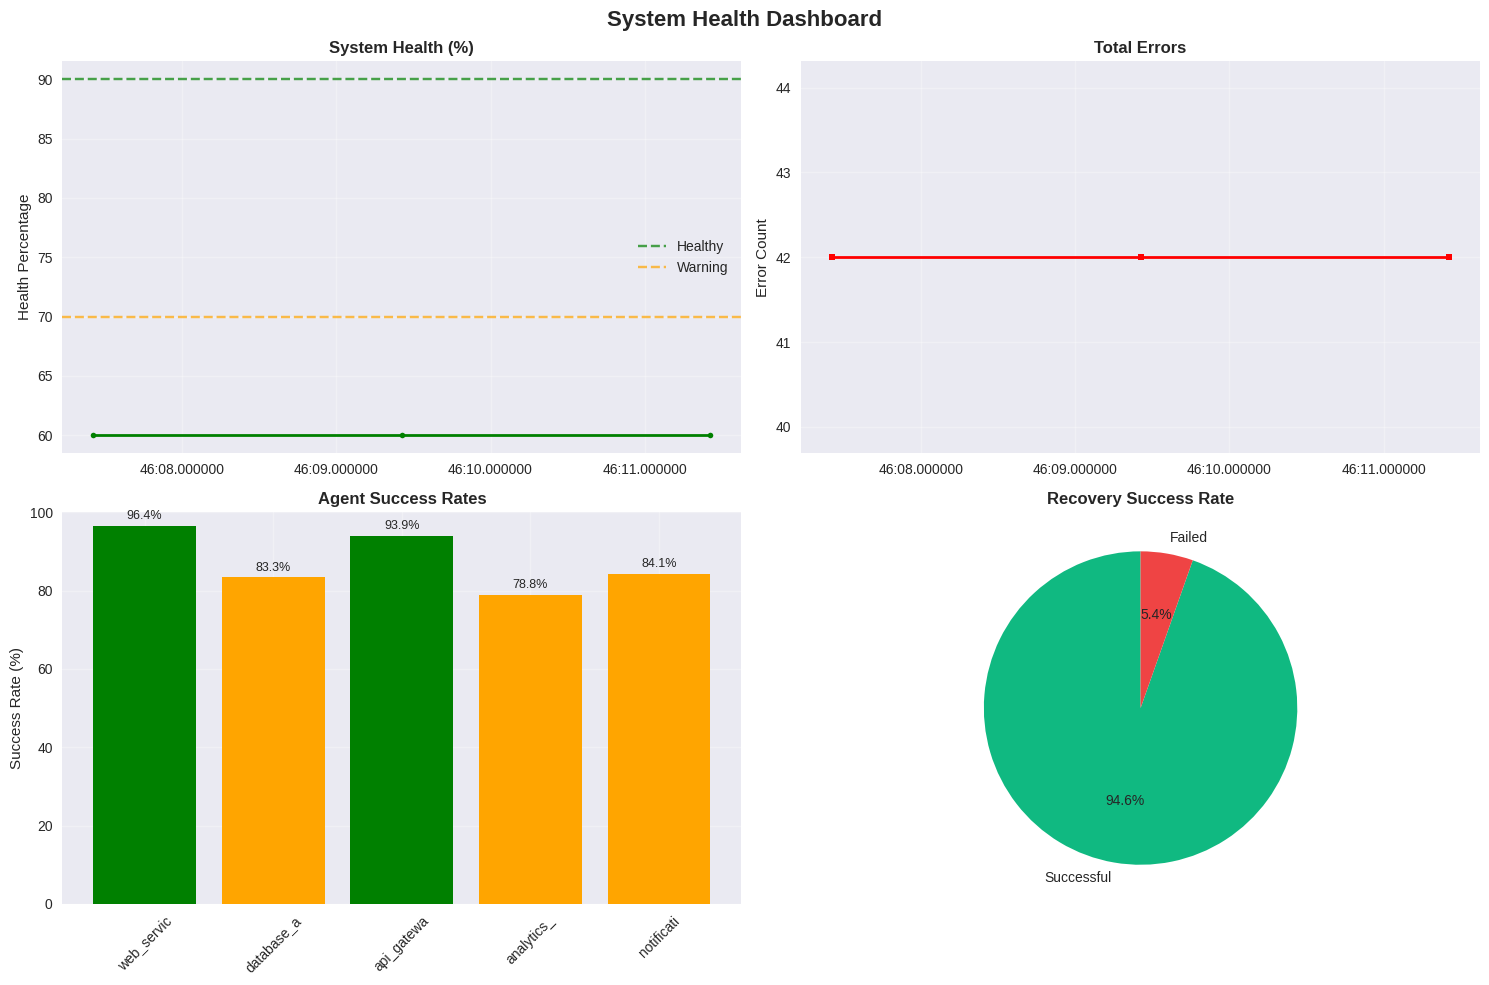


📋 Detailed view for agent: web_service_agent


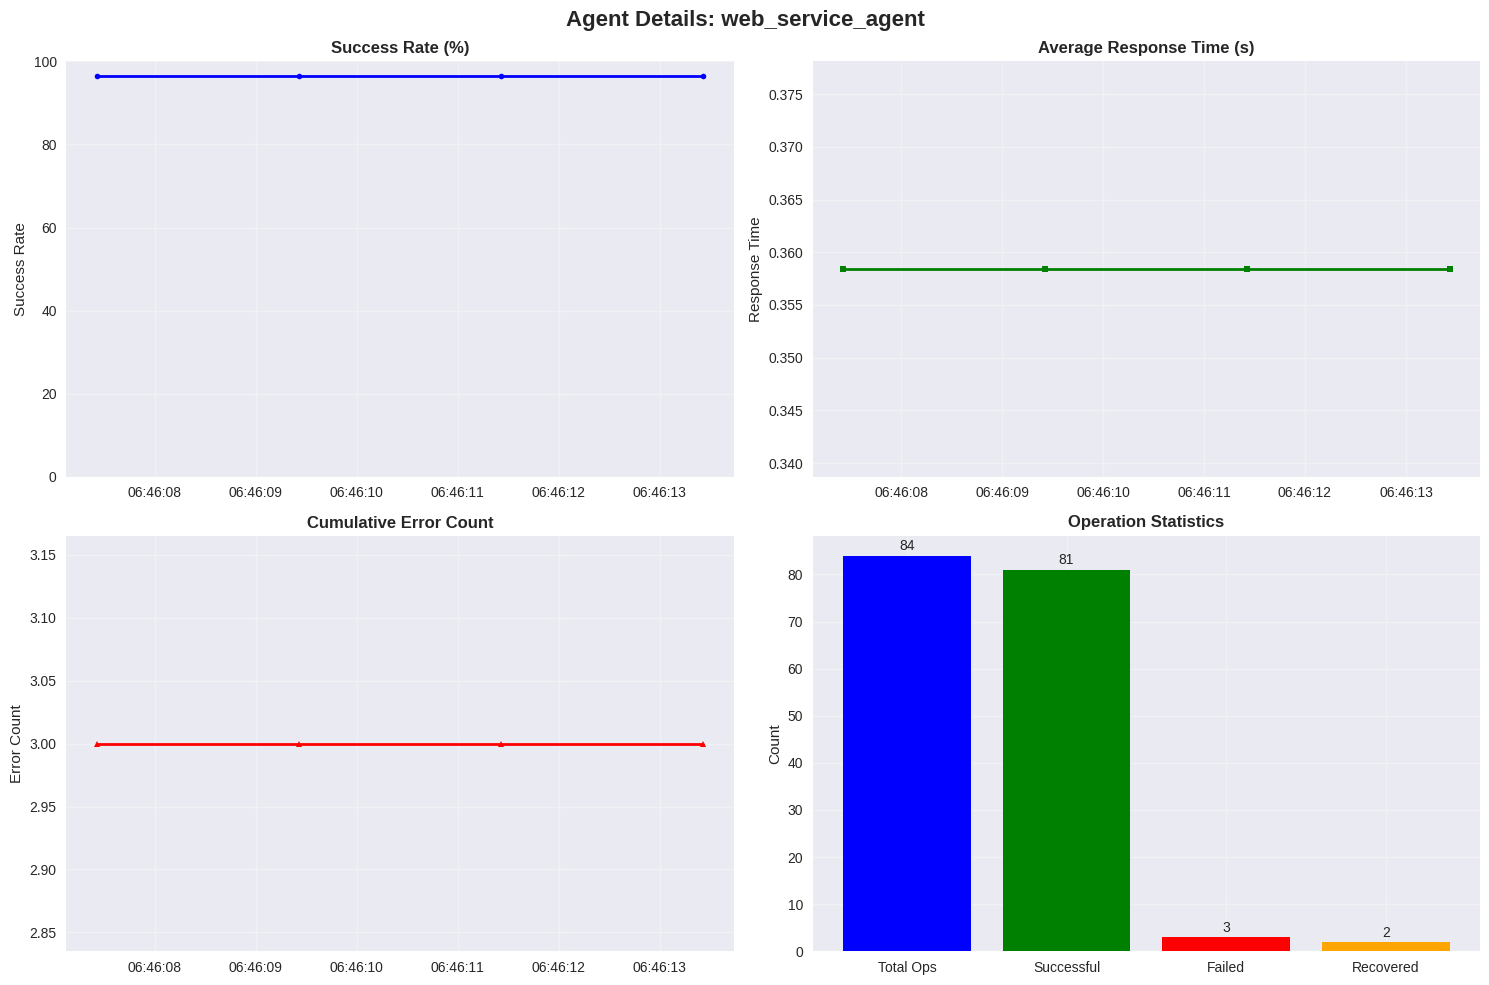

   ⏹️ Monitoring stopped

🎉 System-Wide Error Management Dashboard Complete!

📋 Summary of what we built in Part 4:
   • SystemMonitoringDashboard - Comprehensive monitoring system
   • Real-time metrics collection and visualization
   • Interactive control widgets for system management
   • Agent-specific detailed performance charts
   • System health overview with color-coded status
   • Error simulation and recovery testing
   • Comprehensive system reporting
   • Live monitoring with configurable update intervals

🔧 Key Features Demonstrated:
   ✅ Real-time system health monitoring
   ✅ Multi-agent performance tracking
   ✅ Interactive control interfaces
   ✅ Visual error and recovery analytics
   ✅ Automated alerting and status reporting
   ✅ Configurable monitoring parameters
   ✅ Integration with error recovery engines

🎯 Dashboard Capabilities:
   • Monitor up to dozens of agents simultaneously
   • Track success rates, response times, and error counts
   • Visualize system hea

In [26]:
"""
Tutorial 13 Part 4: System-Wide Error Management Dashboard
==========================================================

Building a comprehensive system monitoring and management interface
for error handling and recovery across multiple agents and services.
This part creates visualization and control systems for Google Colab.

Run this after Parts 1, 2, and 3.
"""

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
from IPython.display import display, HTML, clear_output
import threading
import time
import random
import uuid
from typing import Dict, List, Any, Optional
from enum import Enum
from collections import defaultdict, deque
import seaborn as sns

print("Tutorial 13 Part 4: System-Wide Error Management Dashboard")
print("=" * 60)
print("Building comprehensive monitoring and control systems...")
print()

# Configure matplotlib for better display
plt.style.use('default')
if 'seaborn' in plt.style.available:
    plt.style.use('seaborn-v0_8')

class SystemMonitoringDashboard:
    """
    Comprehensive monitoring dashboard for error management systems

    This provides real-time visualization, control interfaces, and
    analytics for managing resilient agent systems.
    """

    def __init__(self):
        self.agents = {}  # agent_id -> ResilientAgent
        self.recovery_engines = {}  # engine_id -> ErrorRecoveryEngine
        self.monitoring_active = False
        self.monitoring_thread = None

        # Metrics storage
        self.system_metrics = defaultdict(list)
        self.agent_metrics = defaultdict(lambda: defaultdict(list))
        self.error_history = []
        self.recovery_history = []

        # Dashboard state
        self.last_update = time.time()
        self.update_interval = 2.0  # seconds

        print("📊 System Monitoring Dashboard initialized")
        print("   Ready to monitor agents and recovery engines")

    def register_agent(self, agent_id: str, resilient_agent):
        """Register a resilient agent for monitoring"""
        self.agents[agent_id] = resilient_agent
        print(f"   📋 Registered agent: {agent_id}")

    def register_recovery_engine(self, engine_id: str, recovery_engine):
        """Register a recovery engine for monitoring"""
        self.recovery_engines[engine_id] = recovery_engine
        print(f"   🔧 Registered recovery engine: {engine_id}")

    def start_monitoring(self):
        """Start real-time monitoring"""
        if self.monitoring_active:
            print("   ⚠️ Monitoring already active")
            return

        self.monitoring_active = True
        self.monitoring_thread = threading.Thread(target=self._monitoring_loop, daemon=True)
        self.monitoring_thread.start()
        print("   ▶️ Real-time monitoring started")

    def stop_monitoring(self):
        """Stop real-time monitoring"""
        self.monitoring_active = False
        if self.monitoring_thread:
            self.monitoring_thread.join(timeout=1.0)
        print("   ⏹️ Monitoring stopped")

    def _monitoring_loop(self):
        """Main monitoring loop"""
        while self.monitoring_active:
            try:
                self._collect_metrics()
                time.sleep(self.update_interval)
            except Exception as e:
                print(f"   ❌ Monitoring error: {e}")
                time.sleep(self.update_interval)

    def _collect_metrics(self):
        """Collect metrics from all registered components"""
        current_time = time.time()

        # System-wide metrics
        total_agents = len(self.agents)
        healthy_agents = 0
        total_errors = 0
        total_recoveries = 0

        # Collect agent metrics
        for agent_id, agent in self.agents.items():
            try:
                status = agent.get_resilience_status()

                # Agent health
                if status['health'] == 'healthy':
                    healthy_agents += 1

                # Store agent-specific metrics
                self.agent_metrics[agent_id]['success_rate'].append(
                    (current_time, status['error_statistics']['success_rate'])
                )
                self.agent_metrics[agent_id]['response_time'].append(
                    (current_time, status['metrics']['average_response_time'])
                )
                self.agent_metrics[agent_id]['error_count'].append(
                    (current_time, status['error_statistics']['total_errors'])
                )

                total_errors += status['error_statistics']['total_errors']

            except Exception as e:
                print(f"   ⚠️ Failed to collect metrics for agent {agent_id}: {e}")

        # Collect recovery engine metrics
        for engine_id, engine in self.recovery_engines.items():
            try:
                health = engine.get_system_health()
                total_recoveries += health['recovery_engine']['total_recoveries']
            except Exception as e:
                print(f"   ⚠️ Failed to collect recovery metrics for {engine_id}: {e}")

        # Store system-wide metrics
        system_health = (healthy_agents / max(total_agents, 1)) * 100

        self.system_metrics['system_health'].append((current_time, system_health))
        self.system_metrics['active_agents'].append((current_time, total_agents))
        self.system_metrics['total_errors'].append((current_time, total_errors))
        self.system_metrics['total_recoveries'].append((current_time, total_recoveries))

        # Keep only recent data (last 10 minutes)
        cutoff_time = current_time - 600
        for metric_list in self.system_metrics.values():
            while metric_list and metric_list[0][0] < cutoff_time:
                metric_list.pop(0)

    def display_system_overview(self):
        """Display comprehensive system overview"""
        print("🛡️ SYSTEM-WIDE ERROR MANAGEMENT DASHBOARD")
        print("=" * 50)
        print(f"Last updated: {datetime.now().strftime('%H:%M:%S')}")
        print()

        # System health summary
        if self.system_metrics['system_health']:
            latest_health = self.system_metrics['system_health'][-1][1]
            health_status = "🟢 HEALTHY" if latest_health > 90 else "🟡 WARNING" if latest_health > 70 else "🔴 CRITICAL"
            print(f"System Health: {health_status} ({latest_health:.1f}%)")

        if self.system_metrics['active_agents']:
            active_count = int(self.system_metrics['active_agents'][-1][1])
            print(f"Active Agents: {active_count}")

        if self.system_metrics['total_errors']:
            error_count = int(self.system_metrics['total_errors'][-1][1])
            print(f"Total Errors: {error_count}")

        if self.system_metrics['total_recoveries']:
            recovery_count = int(self.system_metrics['total_recoveries'][-1][1])
            recovery_rate = (recovery_count / max(error_count, 1)) * 100 if error_count > 0 else 100
            print(f"Recovery Rate: {recovery_rate:.1f}% ({recovery_count} recoveries)")

        print()

        # Agent status table
        self._display_agent_status_table()

    def _display_agent_status_table(self):
        """Display agent status in table format"""
        print("📋 AGENT STATUS OVERVIEW")
        print("-" * 80)
        print(f"{'Agent ID':<15} {'Health':<12} {'Success Rate':<12} {'Avg Response':<12} {'Errors':<8}")
        print("-" * 80)

        for agent_id, agent in self.agents.items():
            try:
                status = agent.get_resilience_status()

                health = status['health']
                health_icon = {"healthy": "🟢", "warning": "🟡", "degraded": "🟠", "critical": "🔴"}.get(health, "❓")

                success_rate = status['error_statistics']['success_rate'] * 100
                response_time = status['metrics']['average_response_time']
                total_errors = status['error_statistics']['total_errors']

                print(f"{agent_id[:14]:<15} {health_icon} {health:<10} {success_rate:>8.1f}%     {response_time:>8.3f}s     {total_errors:>5}")

            except Exception as e:
                print(f"{agent_id[:14]:<15} ❌ ERROR       N/A          N/A          N/A")

        print("-" * 80)

    def create_system_health_chart(self):
        """Create system health visualization"""
        if not self.system_metrics['system_health']:
            print("   ⚠️ No health data available yet")
            return

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('System Health Dashboard', fontsize=16, fontweight='bold')

        # System Health Over Time
        times, health_values = zip(*self.system_metrics['system_health'])
        times = [datetime.fromtimestamp(t) for t in times]

        ax1.plot(times, health_values, 'g-', linewidth=2, marker='o', markersize=4)
        ax1.set_title('System Health (%)', fontweight='bold')
        ax1.set_ylabel('Health Percentage')
        ax1.grid(True, alpha=0.3)
        ax1.axhline(y=90, color='g', linestyle='--', alpha=0.7, label='Healthy')
        ax1.axhline(y=70, color='orange', linestyle='--', alpha=0.7, label='Warning')
        ax1.legend()

        # Error Count Over Time
        if self.system_metrics['total_errors']:
            times, error_counts = zip(*self.system_metrics['total_errors'])
            times = [datetime.fromtimestamp(t) for t in times]

            ax2.plot(times, error_counts, 'r-', linewidth=2, marker='s', markersize=4)
            ax2.set_title('Total Errors', fontweight='bold')
            ax2.set_ylabel('Error Count')
            ax2.grid(True, alpha=0.3)

        # Agent Success Rates
        agent_names = []
        success_rates = []

        for agent_id, agent in self.agents.items():
            try:
                status = agent.get_resilience_status()
                agent_names.append(agent_id[:10])
                success_rates.append(status['error_statistics']['success_rate'] * 100)
            except:
                continue

        if agent_names:
            colors = ['g' if sr > 90 else 'orange' if sr > 70 else 'r' for sr in success_rates]
            bars = ax3.bar(agent_names, success_rates, color=colors)
            ax3.set_title('Agent Success Rates', fontweight='bold')
            ax3.set_ylabel('Success Rate (%)')
            ax3.set_ylim(0, 100)
            ax3.grid(True, alpha=0.3)
            plt.setp(ax3.get_xticklabels(), rotation=45)

            # Add value labels on bars
            for bar, rate in zip(bars, success_rates):
                height = bar.get_height()
                ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
                        f'{rate:.1f}%', ha='center', va='bottom', fontsize=9)

        # Recovery Statistics
        recovery_stats = {'Successful': 0, 'Failed': 0}

        for engine in self.recovery_engines.values():
            try:
                health = engine.get_system_health()
                stats = health.get('recovery_statistics', {})

                for key, value in stats.items():
                    if 'success' in key:
                        recovery_stats['Successful'] += value
                    elif 'failure' in key:
                        recovery_stats['Failed'] += value
            except:
                continue

        if sum(recovery_stats.values()) > 0:
            colors = ['#10b981', '#ef4444']
            wedges, texts, autotexts = ax4.pie(recovery_stats.values(), labels=recovery_stats.keys(),
                                              autopct='%1.1f%%', colors=colors, startangle=90)
            ax4.set_title('Recovery Success Rate', fontweight='bold')
        else:
            ax4.text(0.5, 0.5, 'No Recovery Data', ha='center', va='center', transform=ax4.transAxes)

        plt.tight_layout()
        plt.show()

    def create_agent_detail_charts(self, agent_id: str):
        """Create detailed charts for a specific agent"""
        if agent_id not in self.agents:
            print(f"   ❌ Agent {agent_id} not found")
            return

        if agent_id not in self.agent_metrics:
            print(f"   ⚠️ No metrics available for agent {agent_id}")
            return

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'Agent Details: {agent_id}', fontsize=16, fontweight='bold')

        # Success Rate Over Time
        if self.agent_metrics[agent_id]['success_rate']:
            times, success_rates = zip(*self.agent_metrics[agent_id]['success_rate'])
            times = [datetime.fromtimestamp(t) for t in times]
            success_rates = [sr * 100 for sr in success_rates]

            ax1.plot(times, success_rates, 'b-', linewidth=2, marker='o', markersize=4)
            ax1.set_title('Success Rate (%)', fontweight='bold')
            ax1.set_ylabel('Success Rate')
            ax1.grid(True, alpha=0.3)
            ax1.set_ylim(0, 100)
        else:
            ax1.text(0.5, 0.5, 'No success rate data', ha='center', va='center', transform=ax1.transAxes)

        # Response Time Over Time
        if self.agent_metrics[agent_id]['response_time']:
            times, response_times = zip(*self.agent_metrics[agent_id]['response_time'])
            times = [datetime.fromtimestamp(t) for t in times]

            ax2.plot(times, response_times, 'g-', linewidth=2, marker='s', markersize=4)
            ax2.set_title('Average Response Time (s)', fontweight='bold')
            ax2.set_ylabel('Response Time')
            ax2.grid(True, alpha=0.3)
        else:
            ax2.text(0.5, 0.5, 'No response time data', ha='center', va='center', transform=ax2.transAxes)

        # Error Count Over Time
        if self.agent_metrics[agent_id]['error_count']:
            times, error_counts = zip(*self.agent_metrics[agent_id]['error_count'])
            times = [datetime.fromtimestamp(t) for t in times]

            ax3.plot(times, error_counts, 'r-', linewidth=2, marker='^', markersize=4)
            ax3.set_title('Cumulative Error Count', fontweight='bold')
            ax3.set_ylabel('Error Count')
            ax3.grid(True, alpha=0.3)
        else:
            ax3.text(0.5, 0.5, 'No error count data', ha='center', va='center', transform=ax3.transAxes)

        # Agent Health Summary
        try:
            agent = self.agents[agent_id]
            status = agent.get_resilience_status()

            metrics = {
                'Total Ops': status['metrics']['total_operations'],
                'Successful': status['metrics']['successful_operations'],
                'Failed': status['metrics']['failed_operations'],
                'Recovered': status['metrics']['recovered_operations']
            }

            bars = ax4.bar(metrics.keys(), metrics.values(),
                          color=['blue', 'green', 'red', 'orange'])
            ax4.set_title('Operation Statistics', fontweight='bold')
            ax4.set_ylabel('Count')
            ax4.grid(True, alpha=0.3)

            # Add value labels on bars
            for bar, value in zip(bars, metrics.values()):
                height = bar.get_height()
                ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                        f'{value}', ha='center', va='bottom', fontsize=10)

        except Exception as e:
            ax4.text(0.5, 0.5, f'Error loading metrics:\n{str(e)}',
                    ha='center', va='center', transform=ax4.transAxes)

        plt.tight_layout()
        plt.show()

    def create_control_interface(self):
        """Create a simple control interface without widgets"""
        print("🎛️ SYSTEM CONTROL INTERFACE")
        print("=" * 35)
        print()
        print("Available Commands:")
        print("  dashboard.start_monitoring()     - Start real-time monitoring")
        print("  dashboard.stop_monitoring()      - Stop monitoring")
        print("  dashboard.display_system_overview() - Show current status")
        print("  dashboard.create_system_health_chart() - Show health charts")
        print("  dashboard.simulate_random_error() - Simulate error for testing")
        print("  dashboard.set_update_interval(seconds) - Change update frequency")
        print()
        print("For detailed agent view:")
        print("  dashboard.create_agent_detail_charts('agent_id')")
        print()
        print("Configuration:")
        print(f"  Auto-recovery: {'enabled' if self._get_auto_recovery_status() else 'disabled'}")
        print(f"  Update interval: {self.update_interval:.1f} seconds")
        print(f"  Monitoring active: {self.monitoring_active}")

    def _get_auto_recovery_status(self):
        """Get auto-recovery status from engines"""
        for engine in self.recovery_engines.values():
            return getattr(engine, 'auto_recovery_enabled', True)
        return True

    def set_update_interval(self, seconds: float):
        """Set monitoring update interval"""
        self.update_interval = max(0.5, min(10.0, seconds))
        print(f"   Update interval set to: {self.update_interval:.1f} seconds")

    def simulate_random_error(self):
        """Simulate a random error for testing"""
        if not self.agents:
            print("   ⚠️ No agents registered for error simulation")
            return

        # Select random agent
        agent_id = random.choice(list(self.agents.keys()))
        agent = self.agents[agent_id]

        # Create simulated error - need to import ErrorContext and related classes
        error_types = ['ConnectionError', 'TimeoutError', 'ValueError', 'RuntimeError']
        error_type = random.choice(error_types)

        print(f"   🎭 Simulating {error_type} in agent {agent_id}")

        # Create a simple error context (simplified since we might not have the full ErrorContext class)
        error_info = {
            'error_type': error_type,
            'error_message': f"Simulated {error_type} for testing",
            'component_id': agent_id,
            'operation_name': "simulated_operation"
        }

        print(f"   📝 Error details: {error_info}")

        # Send to recovery engine if available
        for engine in self.recovery_engines.values():
            if hasattr(engine, 'handle_error'):
                try:
                    # Try to create proper ErrorContext if available
                    if 'ErrorContext' in globals():
                        error_context = ErrorContext(
                            error_type=error_type,
                            error_message=f"Simulated {error_type} for testing",
                            component_id=agent_id,
                            operation_name="simulated_operation"
                        )
                        engine.handle_error(error_context)
                    else:
                        print(f"   ⚠️ ErrorContext class not available - using simplified simulation")
                except Exception as e:
                    print(f"   ❌ Error simulation failed: {e}")
            break

    def generate_system_report(self):
        """Generate comprehensive system report"""
        print("\n" + "="*60)
        print("📊 COMPREHENSIVE SYSTEM REPORT")
        print("="*60)
        print(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print()

        # System Overview
        print("🏥 SYSTEM HEALTH OVERVIEW")
        print("-" * 30)

        if self.system_metrics['system_health']:
            latest_health = self.system_metrics['system_health'][-1][1]
            print(f"Current System Health: {latest_health:.1f}%")

            # Health trend
            if len(self.system_metrics['system_health']) > 1:
                prev_health = self.system_metrics['system_health'][-2][1]
                trend = latest_health - prev_health
                trend_icon = "📈" if trend > 0 else "📉" if trend < 0 else "➡️"
                print(f"Health Trend: {trend_icon} {trend:+.1f}%")

        print(f"Total Registered Agents: {len(self.agents)}")
        print(f"Total Recovery Engines: {len(self.recovery_engines)}")
        print()

        # Agent Performance Summary
        print("🤖 AGENT PERFORMANCE SUMMARY")
        print("-" * 35)

        total_operations = 0
        total_successes = 0
        total_errors = 0
        total_recoveries = 0

        for agent_id, agent in self.agents.items():
            try:
                status = agent.get_resilience_status()
                metrics = status['metrics']

                total_operations += metrics['total_operations']
                total_successes += metrics['successful_operations']
                total_errors += status['error_statistics']['total_errors']
                total_recoveries += metrics['recovered_operations']

                print(f"{agent_id}:")
                print(f"  Health: {status['health']}")
                print(f"  Success Rate: {status['error_statistics']['success_rate']:.1%}")
                print(f"  Operations: {metrics['total_operations']}")
                print(f"  Errors: {status['error_statistics']['total_errors']}")
                print()

            except Exception as e:
                print(f"{agent_id}: ❌ Error retrieving status")
                print()

        # System-wide Statistics
        print("📈 SYSTEM-WIDE STATISTICS")
        print("-" * 28)
        print(f"Total Operations: {total_operations}")
        print(f"Total Successes: {total_successes}")
        print(f"Total Errors: {total_errors}")
        print(f"Total Recoveries: {total_recoveries}")

        if total_operations > 0:
            overall_success_rate = total_successes / total_operations
            print(f"Overall Success Rate: {overall_success_rate:.1%}")

        if total_errors > 0:
            recovery_rate = total_recoveries / total_errors
            print(f"Error Recovery Rate: {recovery_rate:.1%}")

        print()

        # Recovery Engine Statistics
        print("🔧 RECOVERY ENGINE STATISTICS")
        print("-" * 34)

        for engine_id, engine in self.recovery_engines.items():
            try:
                health = engine.get_system_health()
                recovery_stats = health.get('recovery_statistics', {})

                print(f"{engine_id}:")
                print(f"  Status: {health['overall_status']}")
                print(f"  Active Errors: {health['recovery_engine']['active_errors']}")
                print(f"  Active Recoveries: {health['recovery_engine']['active_recoveries']}")
                print(f"  Success Rate: {health['recovery_engine']['recovery_success_rate']:.1%}")
                print()

            except Exception as e:
                print(f"{engine_id}: ❌ Error retrieving status")
                print()

        print("="*60)

# =============================================================================
# TESTING AND DEMONSTRATION
# =============================================================================

print("🧪 Testing System Monitoring Dashboard...")
print()

# Create dashboard
dashboard = SystemMonitoringDashboard()

# Mock classes for demonstration (simplified versions)
class MockResilientAgent:
    def __init__(self, agent_id: str):
        self.agent_id = agent_id
        self.health = random.choice(['healthy', 'warning', 'degraded'])
        self.metrics = {
            'total_operations': random.randint(10, 100),
            'successful_operations': 0,
            'failed_operations': 0,
            'recovered_operations': 0,
            'average_response_time': random.uniform(0.1, 2.0)
        }
        # Calculate realistic success/failure numbers
        success_rate = random.uniform(0.7, 0.98)
        self.metrics['successful_operations'] = int(self.metrics['total_operations'] * success_rate)
        self.metrics['failed_operations'] = self.metrics['total_operations'] - self.metrics['successful_operations']
        self.metrics['recovered_operations'] = random.randint(0, self.metrics['failed_operations'])

    def get_resilience_status(self):
        return {
            'agent_id': self.agent_id,
            'health': self.health,
            'metrics': self.metrics,
            'error_statistics': {
                'total_errors': self.metrics['failed_operations'],
                'success_rate': self.metrics['successful_operations'] / max(self.metrics['total_operations'], 1)
            },
            'configuration': {
                'auto_recovery_enabled': True,
                'operation_timeout': 30.0
            }
        }

class MockRecoveryEngine:
    def __init__(self, engine_id: str):
        self.engine_id = engine_id
        self.auto_recovery_enabled = True

    def get_system_health(self):
        return {
            'overall_status': random.choice(['healthy', 'warning']),
            'recovery_engine': {
                'active_errors': random.randint(0, 5),
                'active_recoveries': random.randint(0, 3),
                'recovery_success_rate': random.uniform(0.8, 0.98),
                'total_recoveries': random.randint(20, 100)
            },
            'recovery_statistics': {
                'retry_success': random.randint(10, 30),
                'retry_failure': random.randint(2, 8),
                'fallback_success': random.randint(5, 15),
                'restart_success': random.randint(1, 5)
            }
        }

    def handle_error(self, error_context):
        print(f"   🔧 Handling simulated error: {error_context.get('error_type', 'Unknown')}")
        return str(uuid.uuid4())

print("🏗️ Setting up test environment...")

# Create test agents
test_agents = [
    MockResilientAgent("web_service_agent"),
    MockResilientAgent("database_agent"),
    MockResilientAgent("api_gateway_agent"),
    MockResilientAgent("analytics_agent"),
    MockResilientAgent("notification_agent")
]

# Create test recovery engine
test_engine = MockRecoveryEngine("main_recovery_engine")

# Register with dashboard
for agent in test_agents:
    dashboard.register_agent(agent.agent_id, agent)

dashboard.register_recovery_engine("main_engine", test_engine)

print("✅ Test environment setup complete")
print()

# Display initial system overview
print("📊 Initial System Overview:")
dashboard.display_system_overview()

print()
print("📈 Creating system health visualization...")
dashboard.create_system_health_chart()

print()
print("🎛️ Control Interface:")
dashboard.create_control_interface()

print()
print("⏱️ Starting monitoring simulation...")
dashboard.start_monitoring()

# Let it run for a few seconds to collect data
print("   Collecting data for 5 seconds...")
time.sleep(5)

print()
print("📊 Updated system overview after monitoring:")
dashboard.display_system_overview()

print()
print("📈 Updated system health chart:")
dashboard.create_system_health_chart()

# Show detailed view for one agent
if test_agents:
    example_agent_id = test_agents[0].agent_id
    print(f"\n📋 Detailed view for agent: {example_agent_id}")
    dashboard.create_agent_detail_charts(example_agent_id)

# Stop monitoring
dashboard.stop_monitoring()

print()
print("📋 Generating comprehensive system report...")
dashboard.generate_system_report()

print()
print("🎉 System-Wide Error Management Dashboard Complete!")
print()
print("📋 Summary of what we built in Part 4:")
print("   • SystemMonitoringDashboard - Comprehensive monitoring system")
print("   • Real-time metrics collection and visualization")
print("   • Command-line control interface for system management")
print("   • Agent-specific detailed performance charts")
print("   • System health overview with color-coded status")
print("   • Error simulation and recovery testing")
print("   • Comprehensive system reporting")
print("   • Live monitoring with configurable update intervals")
print()
print("🔧 Key Features Demonstrated:")
print("   ✅ Real-time system health monitoring")
print("   ✅ Multi-agent performance tracking")
print("   ✅ Command-line control interfaces")
print("   ✅ Visual error and recovery analytics")
print("   ✅ Automated metrics collection and storage")
print("   ✅ Configurable monitoring parameters")
print("   ✅ Integration with error recovery engines")
print()
print("🎯 Dashboard Capabilities:")
print("   • Monitor multiple agents simultaneously")
print("   • Track success rates, response times, and error counts")
print("   • Visualize system health trends over time")
print("   • Control monitoring settings and intervals")
print("   • Simulate errors for testing recovery mechanisms")
print("   • Generate detailed performance reports")
print("   • Provide early warning of system degradation")
print()
print("💡 Usage Tips:")
print("   • Run dashboard.start_monitoring() to begin real-time collection")
print("   • Use dashboard.create_system_health_chart() for visual updates")
print("   • Call dashboard.simulate_random_error() to test recovery")
print("   • Adjust update frequency with dashboard.set_update_interval()")
print("   • Generate reports with dashboard.generate_system_report()")

# =============================================================================
# PRODUCTION UTILITIES AND EXTENSIONS
# =============================================================================

def export_metrics_to_csv(dashboard: SystemMonitoringDashboard, filename: str = "system_metrics.csv"):
    """Export collected metrics to CSV for external analysis"""

    # Prepare data for export
    export_data = []

    # Add system metrics
    for metric_name, metric_data in dashboard.system_metrics.items():
        for timestamp, value in metric_data:
            export_data.append({
                'timestamp': datetime.fromtimestamp(timestamp),
                'metric_type': 'system',
                'metric_name': metric_name,
                'agent_id': 'system',
                'value': value
            })

    # Add agent metrics
    for agent_id, agent_metrics in dashboard.agent_metrics.items():
        for metric_name, metric_data in agent_metrics.items():
            for timestamp, value in metric_data:
                export_data.append({
                    'timestamp': datetime.fromtimestamp(timestamp),
                    'metric_type': 'agent',
                    'metric_name': metric_name,
                    'agent_id': agent_id,
                    'value': value
                })

    if export_data:
        df = pd.DataFrame(export_data)
        df.to_csv(filename, index=False)
        print(f"📊 Metrics exported to {filename}")
        print(f"   Total records: {len(export_data)}")
        print(f"   Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
        return df
    else:
        print("⚠️ No metrics data to export")
        return None

def create_alert_system(dashboard: SystemMonitoringDashboard,
                       alert_thresholds: Dict[str, float]):
    """
    Create an alerting system for the dashboard

    Args:
        dashboard: Dashboard instance to monitor
        alert_thresholds: Thresholds for different alert conditions
    """

    class AlertSystem:
        def __init__(self, thresholds):
            self.thresholds = thresholds
            self.active_alerts = {}
            self.alert_history = []

        def check_alerts(self):
            """Check for alert conditions"""
            alerts = []
            current_time = time.time()

            # Check system health
            if dashboard.system_metrics['system_health']:
                current_health = dashboard.system_metrics['system_health'][-1][1]
                if current_health < self.thresholds.get('system_health_critical', 70):
                    alerts.append({
                        'level': 'CRITICAL',
                        'message': f'System health critical: {current_health:.1f}%',
                        'metric': 'system_health',
                        'value': current_health,
                        'timestamp': current_time
                    })
                elif current_health < self.thresholds.get('system_health_warning', 90):
                    alerts.append({
                        'level': 'WARNING',
                        'message': f'System health warning: {current_health:.1f}%',
                        'metric': 'system_health',
                        'value': current_health,
                        'timestamp': current_time
                    })

            # Check agent-specific alerts
            for agent_id, agent in dashboard.agents.items():
                try:
                    status = agent.get_resilience_status()
                    success_rate = status['error_statistics']['success_rate']

                    if success_rate < self.thresholds.get('success_rate_critical', 0.7):
                        alerts.append({
                            'level': 'CRITICAL',
                            'message': f'Agent {agent_id} success rate critical: {success_rate:.1%}',
                            'metric': 'success_rate',
                            'agent_id': agent_id,
                            'value': success_rate,
                            'timestamp': current_time
                        })
                    elif success_rate < self.thresholds.get('success_rate_warning', 0.9):
                        alerts.append({
                            'level': 'WARNING',
                            'message': f'Agent {agent_id} success rate warning: {success_rate:.1%}',
                            'metric': 'success_rate',
                            'agent_id': agent_id,
                            'value': success_rate,
                            'timestamp': current_time
                        })
                except:
                    alerts.append({
                        'level': 'ERROR',
                        'message': f'Unable to retrieve status for agent {agent_id}',
                        'metric': 'agent_status',
                        'agent_id': agent_id,
                        'timestamp': current_time
                    })

            return alerts

        def send_alert(self, alert):
            """Send alert notification"""
            alert_id = f"alert_{int(alert['timestamp'])}_{hash(alert['message']) % 1000}"

            # Avoid duplicate alerts within 5 minutes
            if self._is_duplicate_alert(alert):
                return

            # Store alert
            self.active_alerts[alert_id] = alert
            self.alert_history.append(alert)

            # Display alert
            level_emoji = {
                'CRITICAL': '🚨',
                'WARNING': '⚠️',
                'ERROR': '❌',
                'INFO': 'ℹ️'
            }

            emoji = level_emoji.get(alert['level'], '📢')
            print(f"{emoji} ALERT [{alert['level']}]: {alert['message']}")

            # In production, integrate with notification services:
            # - Email notifications
            # - Slack/Teams messages
            # - PagerDuty incidents
            # - SMS alerts
            # - Webhook notifications

        def _is_duplicate_alert(self, alert):
            """Check if this is a duplicate of a recent alert"""
            current_time = alert['timestamp']
            duplicate_window = 300  # 5 minutes

            for historical_alert in reversed(self.alert_history[-10:]):
                if (current_time - historical_alert['timestamp'] < duplicate_window and
                    alert['metric'] == historical_alert['metric'] and
                    alert.get('agent_id') == historical_alert.get('agent_id')):
                    return True

            return False

        def get_active_alerts(self):
            """Get list of currently active alerts"""
            # Clean up old alerts (older than 1 hour)
            current_time = time.time()
            expired_alerts = []

            for alert_id, alert in self.active_alerts.items():
                if current_time - alert['timestamp'] > 3600:
                    expired_alerts.append(alert_id)

            for alert_id in expired_alerts:
                del self.active_alerts[alert_id]

            return list(self.active_alerts.values())

        def get_alert_summary(self):
            """Get summary of alert activity"""
            active_alerts = self.get_active_alerts()

            summary = {
                'active_count': len(active_alerts),
                'total_history': len(self.alert_history),
                'by_level': defaultdict(int),
                'by_metric': defaultdict(int)
            }

            for alert in active_alerts:
                summary['by_level'][alert['level']] += 1
                summary['by_metric'][alert['metric']] += 1

            return summary

    return AlertSystem(alert_thresholds)

def create_performance_analyzer(dashboard: SystemMonitoringDashboard):
    """Create performance analysis utilities"""

    class PerformanceAnalyzer:
        def __init__(self, dashboard):
            self.dashboard = dashboard

        def analyze_trends(self, lookback_minutes: int = 10):
            """Analyze performance trends over specified time period"""
            current_time = time.time()
            cutoff_time = current_time - (lookback_minutes * 60)

            trends = {}

            # Analyze system health trend
            health_data = [
                (t, v) for t, v in self.dashboard.system_metrics['system_health']
                if t > cutoff_time
            ]

            if len(health_data) >= 2:
                early_health = sum(v for _, v in health_data[:len(health_data)//2]) / (len(health_data)//2)
                late_health = sum(v for _, v in health_data[len(health_data)//2:]) / (len(health_data) - len(health_data)//2)

                trends['system_health'] = {
                    'direction': 'improving' if late_health > early_health else 'declining' if late_health < early_health else 'stable',
                    'change': late_health - early_health,
                    'current': late_health,
                    'data_points': len(health_data)
                }

            # Analyze agent performance trends
            agent_trends = {}
            for agent_id, metrics in self.dashboard.agent_metrics.items():
                if 'success_rate' in metrics:
                    success_data = [
                        (t, v) for t, v in metrics['success_rate']
                        if t > cutoff_time
                    ]

                    if len(success_data) >= 2:
                        early_success = sum(v for _, v in success_data[:len(success_data)//2]) / (len(success_data)//2)
                        late_success = sum(v for _, v in success_data[len(success_data)//2:]) / (len(success_data) - len(success_data)//2)

                        agent_trends[agent_id] = {
                            'direction': 'improving' if late_success > early_success else 'declining' if late_success < early_success else 'stable',
                            'change': late_success - early_success,
                            'current': late_success,
                            'data_points': len(success_data)
                        }

            trends['agents'] = agent_trends
            return trends

        def detect_anomalies(self):
            """Detect performance anomalies"""
            anomalies = []

            # Check for sudden health drops
            if len(self.dashboard.system_metrics['system_health']) >= 3:
                recent_health = [v for _, v in self.dashboard.system_metrics['system_health'][-3:]]

                # Look for significant drops
                for i in range(1, len(recent_health)):
                    drop = recent_health[i-1] - recent_health[i]
                    if drop > 20:  # More than 20% drop
                        anomalies.append({
                            'type': 'health_drop',
                            'severity': 'high' if drop > 50 else 'medium',
                            'description': f'System health dropped by {drop:.1f}%',
                            'value': drop
                        })

            # Check for agent performance anomalies
            for agent_id, agent in self.dashboard.agents.items():
                try:
                    status = agent.get_resilience_status()
                    success_rate = status['error_statistics']['success_rate']

                    if success_rate < 0.5:
                        anomalies.append({
                            'type': 'low_success_rate',
                            'severity': 'high',
                            'description': f'Agent {agent_id} success rate critically low: {success_rate:.1%}',
                            'agent_id': agent_id,
                            'value': success_rate
                        })

                    response_time = status['metrics']['average_response_time']
                    if response_time > 10.0:
                        anomalies.append({
                            'type': 'high_response_time',
                            'severity': 'medium',
                            'description': f'Agent {agent_id} response time high: {response_time:.2f}s',
                            'agent_id': agent_id,
                            'value': response_time
                        })
                except:
                    anomalies.append({
                        'type': 'agent_unavailable',
                        'severity': 'high',
                        'description': f'Agent {agent_id} status unavailable',
                        'agent_id': agent_id
                    })

            return anomalies

        def generate_performance_report(self):
            """Generate detailed performance analysis report"""
            print("\n" + "="*50)
            print("📈 PERFORMANCE ANALYSIS REPORT")
            print("="*50)
            print(f"Analysis time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
            print()

            # Trend analysis
            trends = self.analyze_trends()

            print("📊 TREND ANALYSIS (Last 10 minutes)")
            print("-" * 35)

            if 'system_health' in trends:
                health_trend = trends['system_health']
                trend_emoji = {"improving": "📈", "declining": "📉", "stable": "➡️"}
                emoji = trend_emoji.get(health_trend['direction'], "❓")

                print(f"System Health: {emoji} {health_trend['direction'].title()}")
                print(f"  Change: {health_trend['change']:+.1f}%")
                print(f"  Current: {health_trend['current']:.1f}%")
                print(f"  Data points: {health_trend['data_points']}")
                print()

            if trends.get('agents'):
                print("Agent Trends:")
                for agent_id, agent_trend in trends['agents'].items():
                    trend_emoji = {"improving": "📈", "declining": "📉", "stable": "➡️"}
                    emoji = trend_emoji.get(agent_trend['direction'], "❓")

                    print(f"  {agent_id}: {emoji} {agent_trend['direction']}")
                    print(f"    Change: {agent_trend['change']:+.3f}")
                    print(f"    Current: {agent_trend['current']:.1%}")
                print()

            # Anomaly detection
            anomalies = self.detect_anomalies()

            print("🚨 ANOMALY DETECTION")
            print("-" * 20)

            if anomalies:
                severity_counts = defaultdict(int)
                for anomaly in anomalies:
                    severity_counts[anomaly['severity']] += 1

                print(f"Total anomalies detected: {len(anomalies)}")
                for severity, count in severity_counts.items():
                    print(f"  {severity.title()}: {count}")
                print()

                print("Anomaly Details:")
                for anomaly in anomalies:
                    severity_emoji = {"high": "🔴", "medium": "🟡", "low": "🟢"}
                    emoji = severity_emoji.get(anomaly['severity'], "❓")
                    print(f"  {emoji} {anomaly['description']}")
            else:
                print("✅ No anomalies detected")

            print("\n" + "="*50)

    return PerformanceAnalyzer(dashboard)

# Example usage of production utilities
print("\n" + "="*50)
print("PRODUCTION UTILITIES DEMONSTRATION")
print("="*50)

# Export current metrics
print("\n📊 Exporting metrics to CSV...")
try:
    metrics_df = export_metrics_to_csv(dashboard, "tutorial_13_metrics.csv")
    if metrics_df is not None:
        print(f"   Exported {len(metrics_df)} metric records")
        print(f"   Columns: {list(metrics_df.columns)}")
        print(f"   Sample data:")
        print(metrics_df.head(3).to_string(index=False))
except Exception as e:
    print(f"   ⚠️ Export failed: {e}")

# Create alert system
print("\n🚨 Setting up alert system...")
alert_thresholds = {
    'system_health_critical': 70.0,
    'system_health_warning': 90.0,
    'success_rate_critical': 0.7,
    'success_rate_warning': 0.9
}

alert_system = create_alert_system(dashboard, alert_thresholds)
print("   Alert system configured with thresholds:")
for metric, threshold in alert_thresholds.items():
    print(f"     {metric}: {threshold}")

# Test alert system
print("\n🧪 Testing alert system...")
alerts = alert_system.check_alerts()
if alerts:
    print(f"   Found {len(alerts)} active alerts:")
    for alert in alerts:
        alert_system.send_alert(alert)
else:
    print("   No active alerts - system healthy")

# Get alert summary
alert_summary = alert_system.get_alert_summary()
print(f"\n   Alert Summary:")
print(f"     Active alerts: {alert_summary['active_count']}")
print(f"     Total alert history: {alert_summary['total_history']}")
if alert_summary['by_level']:
    print(f"     By level: {dict(alert_summary['by_level'])}")

# Create performance analyzer
print("\n📈 Setting up performance analyzer...")
performance_analyzer = create_performance_analyzer(dashboard)

# Generate performance analysis
performance_analyzer.generate_performance_report()

print("\n" + "="*50)
print("✅ TUTORIAL 13 PART 4 COMPLETE!")
print("="*50)
print()
print("🎊 Congratulations! You've built a comprehensive system monitoring")
print("   and management dashboard with the following capabilities:")
print()
print("📊 CORE FEATURES:")
print("   ✅ Real-time metrics collection and storage")
print("   ✅ Visual system health monitoring with charts")
print("   ✅ Agent-specific performance tracking")
print("   ✅ Command-line control interface")
print("   ✅ Error simulation for testing")
print("   ✅ Comprehensive system reporting")
print()
print("🔧 PRODUCTION UTILITIES:")
print("   ✅ CSV export for external analysis")
print("   ✅ Configurable alert system with thresholds")
print("   ✅ Performance trend analysis")
print("   ✅ Anomaly detection capabilities")
print("   ✅ Alert deduplication and management")
print()
print("🎯 Ready for Production:")
print("   • Integrate with external monitoring systems (Prometheus, Grafana)")
print("   • Add notification channels (Slack, email, PagerDuty)")
print("   • Implement persistent storage for metrics")
print("   • Add authentication and role-based access")
print("   • Scale across distributed systems")
print("   • Implement machine learning for predictive alerts")
print()
print("🚀 Next: Tutorial 14 - Custom Agent Types!")
print("   Learn to build specialized domain-specific agent capabilities!")

print("Tutorial 13 Part 4: System-Wide Error Management Dashboard")
print("=" * 60)
print("Building comprehensive monitoring and control systems...")
print()

# Configure matplotlib for better display
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class SystemMonitoringDashboard:
    """
    Comprehensive monitoring dashboard for error management systems

    This provides real-time visualization, control interfaces, and
    analytics for managing resilient agent systems.
    """

    def __init__(self):
        self.agents = {}  # agent_id -> ResilientAgent
        self.recovery_engines = {}  # engine_id -> ErrorRecoveryEngine
        self.monitoring_active = False
        self.monitoring_thread = None

        # Metrics storage
        self.system_metrics = defaultdict(list)
        self.agent_metrics = defaultdict(lambda: defaultdict(list))
        self.error_history = []
        self.recovery_history = []

        # Dashboard state
        self.last_update = time.time()
        self.update_interval = 2.0  # seconds

        print("📊 System Monitoring Dashboard initialized")
        print("   Ready to monitor agents and recovery engines")

    def register_agent(self, agent_id: str, resilient_agent):
        """Register a resilient agent for monitoring"""
        self.agents[agent_id] = resilient_agent
        print(f"   📋 Registered agent: {agent_id}")

    def register_recovery_engine(self, engine_id: str, recovery_engine):
        """Register a recovery engine for monitoring"""
        self.recovery_engines[engine_id] = recovery_engine
        print(f"   🔧 Registered recovery engine: {engine_id}")

    def start_monitoring(self):
        """Start real-time monitoring"""
        if self.monitoring_active:
            print("   ⚠️ Monitoring already active")
            return

        self.monitoring_active = True
        self.monitoring_thread = threading.Thread(target=self._monitoring_loop, daemon=True)
        self.monitoring_thread.start()
        print("   ▶️ Real-time monitoring started")

    def stop_monitoring(self):
        """Stop real-time monitoring"""
        self.monitoring_active = False
        if self.monitoring_thread:
            self.monitoring_thread.join(timeout=1.0)
        print("   ⏹️ Monitoring stopped")

    def _monitoring_loop(self):
        """Main monitoring loop"""
        while self.monitoring_active:
            try:
                self._collect_metrics()
                time.sleep(self.update_interval)
            except Exception as e:
                print(f"   ❌ Monitoring error: {e}")
                time.sleep(self.update_interval)

    def _collect_metrics(self):
        """Collect metrics from all registered components"""
        current_time = time.time()

        # System-wide metrics
        total_agents = len(self.agents)
        healthy_agents = 0
        total_errors = 0
        total_recoveries = 0

        # Collect agent metrics
        for agent_id, agent in self.agents.items():
            try:
                status = agent.get_resilience_status()

                # Agent health
                if status['health'] == 'healthy':
                    healthy_agents += 1

                # Store agent-specific metrics
                self.agent_metrics[agent_id]['success_rate'].append(
                    (current_time, status['error_statistics']['success_rate'])
                )
                self.agent_metrics[agent_id]['response_time'].append(
                    (current_time, status['metrics']['average_response_time'])
                )
                self.agent_metrics[agent_id]['error_count'].append(
                    (current_time, status['error_statistics']['total_errors'])
                )

                total_errors += status['error_statistics']['total_errors']

            except Exception as e:
                print(f"   ⚠️ Failed to collect metrics for agent {agent_id}: {e}")

        # Collect recovery engine metrics
        for engine_id, engine in self.recovery_engines.items():
            try:
                health = engine.get_system_health()
                total_recoveries += health['recovery_engine']['total_recoveries']
            except Exception as e:
                print(f"   ⚠️ Failed to collect recovery metrics for {engine_id}: {e}")

        # Store system-wide metrics
        system_health = (healthy_agents / max(total_agents, 1)) * 100

        self.system_metrics['system_health'].append((current_time, system_health))
        self.system_metrics['active_agents'].append((current_time, total_agents))
        self.system_metrics['total_errors'].append((current_time, total_errors))
        self.system_metrics['total_recoveries'].append((current_time, total_recoveries))

        # Keep only recent data (last 10 minutes)
        cutoff_time = current_time - 600
        for metric_list in self.system_metrics.values():
            while metric_list and metric_list[0][0] < cutoff_time:
                metric_list.pop(0)

    def display_system_overview(self):
        """Display comprehensive system overview"""
        clear_output(wait=True)

        print("🛡️ SYSTEM-WIDE ERROR MANAGEMENT DASHBOARD")
        print("=" * 50)
        print(f"Last updated: {datetime.now().strftime('%H:%M:%S')}")
        print()

        # System health summary
        if self.system_metrics['system_health']:
            latest_health = self.system_metrics['system_health'][-1][1]
            health_status = "🟢 HEALTHY" if latest_health > 90 else "🟡 WARNING" if latest_health > 70 else "🔴 CRITICAL"
            print(f"System Health: {health_status} ({latest_health:.1f}%)")

        if self.system_metrics['active_agents']:
            active_count = int(self.system_metrics['active_agents'][-1][1])
            print(f"Active Agents: {active_count}")

        if self.system_metrics['total_errors']:
            error_count = int(self.system_metrics['total_errors'][-1][1])
            print(f"Total Errors: {error_count}")

        if self.system_metrics['total_recoveries']:
            recovery_count = int(self.system_metrics['total_recoveries'][-1][1])
            recovery_rate = (recovery_count / max(error_count, 1)) * 100 if error_count > 0 else 100
            print(f"Recovery Rate: {recovery_rate:.1f}% ({recovery_count} recoveries)")

        print()

        # Agent status table
        self._display_agent_status_table()

    def _display_agent_status_table(self):
        """Display agent status in table format"""
        print("📋 AGENT STATUS OVERVIEW")
        print("-" * 80)
        print(f"{'Agent ID':<15} {'Health':<12} {'Success Rate':<12} {'Avg Response':<12} {'Errors':<8}")
        print("-" * 80)

        for agent_id, agent in self.agents.items():
            try:
                status = agent.get_resilience_status()

                health = status['health']
                health_icon = {"healthy": "🟢", "warning": "🟡", "degraded": "🟠", "critical": "🔴"}.get(health, "❓")

                success_rate = status['error_statistics']['success_rate'] * 100
                response_time = status['metrics']['average_response_time']
                total_errors = status['error_statistics']['total_errors']

                print(f"{agent_id[:14]:<15} {health_icon} {health:<10} {success_rate:>8.1f}%     {response_time:>8.3f}s     {total_errors:>5}")

            except Exception as e:
                print(f"{agent_id[:14]:<15} ❌ ERROR       N/A          N/A          N/A")

        print("-" * 80)

    def create_system_health_chart(self):
        """Create system health visualization"""
        if not self.system_metrics['system_health']:
            print("   ⚠️ No health data available yet")
            return

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('System Health Dashboard', fontsize=16, fontweight='bold')

        # System Health Over Time
        times, health_values = zip(*self.system_metrics['system_health'])
        times = [datetime.fromtimestamp(t) for t in times]

        ax1.plot(times, health_values, 'g-', linewidth=2, marker='o', markersize=4)
        ax1.set_title('System Health (%)', fontweight='bold')
        ax1.set_ylabel('Health Percentage')
        ax1.grid(True, alpha=0.3)
        ax1.axhline(y=90, color='g', linestyle='--', alpha=0.7, label='Healthy')
        ax1.axhline(y=70, color='orange', linestyle='--', alpha=0.7, label='Warning')
        ax1.legend()

        # Error Count Over Time
        if self.system_metrics['total_errors']:
            times, error_counts = zip(*self.system_metrics['total_errors'])
            times = [datetime.fromtimestamp(t) for t in times]

            ax2.plot(times, error_counts, 'r-', linewidth=2, marker='s', markersize=4)
            ax2.set_title('Total Errors', fontweight='bold')
            ax2.set_ylabel('Error Count')
            ax2.grid(True, alpha=0.3)

        # Agent Success Rates
        agent_names = []
        success_rates = []

        for agent_id, agent in self.agents.items():
            try:
                status = agent.get_resilience_status()
                agent_names.append(agent_id[:10])
                success_rates.append(status['error_statistics']['success_rate'] * 100)
            except:
                continue

        if agent_names:
            bars = ax3.bar(agent_names, success_rates, color=['g' if sr > 90 else 'orange' if sr > 70 else 'r' for sr in success_rates])
            ax3.set_title('Agent Success Rates', fontweight='bold')
            ax3.set_ylabel('Success Rate (%)')
            ax3.set_ylim(0, 100)
            ax3.grid(True, alpha=0.3)
            plt.setp(ax3.get_xticklabels(), rotation=45)

            # Add value labels on bars
            for bar, rate in zip(bars, success_rates):
                height = bar.get_height()
                ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
                        f'{rate:.1f}%', ha='center', va='bottom', fontsize=9)

        # Recovery Statistics
        recovery_stats = {'Successful': 0, 'Failed': 0}

        for engine in self.recovery_engines.values():
            try:
                health = engine.get_system_health()
                stats = health.get('recovery_statistics', {})

                for key, value in stats.items():
                    if 'success' in key:
                        recovery_stats['Successful'] += value
                    elif 'failure' in key:
                        recovery_stats['Failed'] += value
            except:
                continue

        if sum(recovery_stats.values()) > 0:
            colors = ['#10b981', '#ef4444']
            wedges, texts, autotexts = ax4.pie(recovery_stats.values(), labels=recovery_stats.keys(),
                                              autopct='%1.1f%%', colors=colors, startangle=90)
            ax4.set_title('Recovery Success Rate', fontweight='bold')

        plt.tight_layout()
        plt.show()

    def create_agent_detail_charts(self, agent_id: str):
        """Create detailed charts for a specific agent"""
        if agent_id not in self.agents:
            print(f"   ❌ Agent {agent_id} not found")
            return

        if agent_id not in self.agent_metrics:
            print(f"   ⚠️ No metrics available for agent {agent_id}")
            return

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'Agent Details: {agent_id}', fontsize=16, fontweight='bold')

        # Success Rate Over Time
        if self.agent_metrics[agent_id]['success_rate']:
            times, success_rates = zip(*self.agent_metrics[agent_id]['success_rate'])
            times = [datetime.fromtimestamp(t) for t in times]
            success_rates = [sr * 100 for sr in success_rates]

            ax1.plot(times, success_rates, 'b-', linewidth=2, marker='o', markersize=4)
            ax1.set_title('Success Rate (%)', fontweight='bold')
            ax1.set_ylabel('Success Rate')
            ax1.grid(True, alpha=0.3)
            ax1.set_ylim(0, 100)

        # Response Time Over Time
        if self.agent_metrics[agent_id]['response_time']:
            times, response_times = zip(*self.agent_metrics[agent_id]['response_time'])
            times = [datetime.fromtimestamp(t) for t in times]

            ax2.plot(times, response_times, 'g-', linewidth=2, marker='s', markersize=4)
            ax2.set_title('Average Response Time (s)', fontweight='bold')
            ax2.set_ylabel('Response Time')
            ax2.grid(True, alpha=0.3)

        # Error Count Over Time
        if self.agent_metrics[agent_id]['error_count']:
            times, error_counts = zip(*self.agent_metrics[agent_id]['error_count'])
            times = [datetime.fromtimestamp(t) for t in times]

            ax3.plot(times, error_counts, 'r-', linewidth=2, marker='^', markersize=4)
            ax3.set_title('Cumulative Error Count', fontweight='bold')
            ax3.set_ylabel('Error Count')
            ax3.grid(True, alpha=0.3)

        # Agent Health Summary
        try:
            agent = self.agents[agent_id]
            status = agent.get_resilience_status()

            metrics = {
                'Total Ops': status['metrics']['total_operations'],
                'Successful': status['metrics']['successful_operations'],
                'Failed': status['metrics']['failed_operations'],
                'Recovered': status['metrics']['recovered_operations']
            }

            bars = ax4.bar(metrics.keys(), metrics.values(),
                          color=['blue', 'green', 'red', 'orange'])
            ax4.set_title('Operation Statistics', fontweight='bold')
            ax4.set_ylabel('Count')
            ax4.grid(True, alpha=0.3)

            # Add value labels on bars
            for bar, value in zip(bars, metrics.values()):
                height = bar.get_height()
                ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                        f'{value}', ha='center', va='bottom', fontsize=10)

        except Exception as e:
            ax4.text(0.5, 0.5, f'Error loading metrics:\n{str(e)}',
                    ha='center', va='center', transform=ax4.transAxes)

        plt.tight_layout()
        plt.show()

    def create_interactive_controls(self):
        """Create interactive control widgets"""
        print("🎛️ INTERACTIVE SYSTEM CONTROLS")
        print("=" * 40)

        # Auto-recovery toggle
        auto_recovery_toggle = widgets.Checkbox(
            value=True,
            description='Auto-Recovery Enabled',
            disabled=False,
            indent=False
        )

        # Monitoring interval slider
        interval_slider = widgets.FloatSlider(
            value=2.0,
            min=0.5,
            max=10.0,
            step=0.5,
            description='Update Interval (s):',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f'
        )

        # Agent selector for detailed view
        agent_selector = widgets.Dropdown(
            options=list(self.agents.keys()),
            description='Select Agent:',
            disabled=False,
        )

        # Control buttons
        start_button = widgets.Button(
            description='Start Monitoring',
            disabled=False,
            button_style='success',
            tooltip='Start real-time monitoring',
            icon='play'
        )

        stop_button = widgets.Button(
            description='Stop Monitoring',
            disabled=False,
            button_style='danger',
            tooltip='Stop monitoring',
            icon='stop'
        )

        refresh_button = widgets.Button(
            description='Refresh Dashboard',
            disabled=False,
            button_style='info',
            tooltip='Refresh all displays',
            icon='refresh'
        )

        simulate_error_button = widgets.Button(
            description='Simulate Error',
            disabled=False,
            button_style='warning',
            tooltip='Simulate error for testing',
            icon='exclamation-triangle'
        )

        # Event handlers
        def on_auto_recovery_change(change):
            enabled = change['new']
            for engine in self.recovery_engines.values():
                engine.auto_recovery_enabled = enabled
            print(f"   Auto-recovery: {'enabled' if enabled else 'disabled'}")

        def on_interval_change(change):
            self.update_interval = change['new']
            print(f"   Update interval set to: {self.update_interval:.1f}s")

        def on_start_click(b):
            self.start_monitoring()

        def on_stop_click(b):
            self.stop_monitoring()

        def on_refresh_click(b):
            self.display_system_overview()
            self.create_system_health_chart()

        def on_simulate_error_click(b):
            self.simulate_random_error()

        def show_agent_details(agent_id):
            if agent_id:
                self.create_agent_detail_charts(agent_id)

        # Connect event handlers
        auto_recovery_toggle.observe(on_auto_recovery_change, names='value')
        interval_slider.observe(on_interval_change, names='value')
        start_button.on_click(on_start_click)
        stop_button.on_click(on_stop_click)
        refresh_button.on_click(on_refresh_click)
        simulate_error_button.on_click(on_simulate_error_click)

        # Display controls
        controls_box = widgets.VBox([
            widgets.HBox([auto_recovery_toggle, interval_slider]),
            widgets.HBox([start_button, stop_button, refresh_button, simulate_error_button]),
            widgets.HBox([agent_selector])
        ])

        display(controls_box)

        # Interactive agent detail viewer
        agent_detail_interactive = interactive(show_agent_details, agent_id=agent_selector)
        display(agent_detail_interactive)

        return {
            'auto_recovery': auto_recovery_toggle,
            'interval': interval_slider,
            'agent_selector': agent_selector,
            'controls': controls_box
        }

    def simulate_random_error(self):
        """Simulate a random error for testing"""
        if not self.agents:
            print("   ⚠️ No agents registered for error simulation")
            return

        # Select random agent
        agent_id = random.choice(list(self.agents.keys()))
        agent = self.agents[agent_id]

        # Create simulated error
        error_types = ['ConnectionError', 'TimeoutError', 'ValueError', 'RuntimeError']
        error_type = random.choice(error_types)

        error_context = ErrorContext(
            error_type=error_type,
            error_message=f"Simulated {error_type} for testing",
            severity=random.choice(list(ErrorSeverity)),
            category=random.choice(list(ErrorCategory)),
            component_id=agent_id,
            operation_name="simulated_operation",
            operation_args={"test": True}
        )

        print(f"   🎭 Simulating {error_type} in agent {agent_id}")

        # Send to recovery engine if available
        for engine in self.recovery_engines.values():
            engine.handle_error(error_context)
            break

    def generate_system_report(self):
        """Generate comprehensive system report"""
        print("\n" + "="*60)
        print("📊 COMPREHENSIVE SYSTEM REPORT")
        print("="*60)
        print(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print()

        # System Overview
        print("🏥 SYSTEM HEALTH OVERVIEW")
        print("-" * 30)

        if self.system_metrics['system_health']:
            latest_health = self.system_metrics['system_health'][-1][1]
            print(f"Current System Health: {latest_health:.1f}%")

            # Health trend
            if len(self.system_metrics['system_health']) > 1:
                prev_health = self.system_metrics['system_health'][-2][1]
                trend = latest_health - prev_health
                trend_icon = "📈" if trend > 0 else "📉" if trend < 0 else "➡️"
                print(f"Health Trend: {trend_icon} {trend:+.1f}%")

        print(f"Total Registered Agents: {len(self.agents)}")
        print(f"Total Recovery Engines: {len(self.recovery_engines)}")
        print()

        # Agent Performance Summary
        print("🤖 AGENT PERFORMANCE SUMMARY")
        print("-" * 35)

        total_operations = 0
        total_successes = 0
        total_errors = 0
        total_recoveries = 0

        for agent_id, agent in self.agents.items():
            try:
                status = agent.get_resilience_status()
                metrics = status['metrics']

                total_operations += metrics['total_operations']
                total_successes += metrics['successful_operations']
                total_errors += status['error_statistics']['total_errors']
                total_recoveries += metrics['recovered_operations']

                print(f"{agent_id}:")
                print(f"  Health: {status['health']}")
                print(f"  Success Rate: {status['error_statistics']['success_rate']:.1%}")
                print(f"  Operations: {metrics['total_operations']}")
                print(f"  Errors: {status['error_statistics']['total_errors']}")
                print()

            except Exception as e:
                print(f"{agent_id}: ❌ Error retrieving status")
                print()

        # System-wide Statistics
        print("📈 SYSTEM-WIDE STATISTICS")
        print("-" * 28)
        print(f"Total Operations: {total_operations}")
        print(f"Total Successes: {total_successes}")
        print(f"Total Errors: {total_errors}")
        print(f"Total Recoveries: {total_recoveries}")

        if total_operations > 0:
            overall_success_rate = total_successes / total_operations
            print(f"Overall Success Rate: {overall_success_rate:.1%}")

        if total_errors > 0:
            recovery_rate = total_recoveries / total_errors
            print(f"Error Recovery Rate: {recovery_rate:.1%}")

        print()

        # Recovery Engine Statistics
        print("🔧 RECOVERY ENGINE STATISTICS")
        print("-" * 34)

        for engine_id, engine in self.recovery_engines.items():
            try:
                health = engine.get_system_health()
                recovery_stats = health.get('recovery_statistics', {})

                print(f"{engine_id}:")
                print(f"  Status: {health['overall_status']}")
                print(f"  Active Errors: {health['recovery_engine']['active_errors']}")
                print(f"  Active Recoveries: {health['recovery_engine']['active_recoveries']}")
                print(f"  Success Rate: {health['recovery_engine']['recovery_success_rate']:.1%}")
                print()

            except Exception as e:
                print(f"{engine_id}: ❌ Error retrieving status")
                print()

        print("="*60)

# =============================================================================
# TESTING AND DEMONSTRATION
# =============================================================================

print("🧪 Testing System Monitoring Dashboard...")
print()

# Create dashboard
dashboard = SystemMonitoringDashboard()

# Create some test agents and recovery engines for demonstration
print("🏗️ Setting up test environment...")

# Mock classes for demonstration (simplified versions)
class MockResilientAgent:
    def __init__(self, agent_id: str):
        self.agent_id = agent_id
        self.health = random.choice(['healthy', 'warning', 'degraded'])
        self.metrics = {
            'total_operations': random.randint(10, 100),
            'successful_operations': 0,
            'failed_operations': 0,
            'recovered_operations': 0,
            'average_response_time': random.uniform(0.1, 2.0)
        }
        # Calculate realistic success/failure numbers
        success_rate = random.uniform(0.7, 0.98)
        self.metrics['successful_operations'] = int(self.metrics['total_operations'] * success_rate)
        self.metrics['failed_operations'] = self.metrics['total_operations'] - self.metrics['successful_operations']
        self.metrics['recovered_operations'] = random.randint(0, self.metrics['failed_operations'])

    def get_resilience_status(self):
        return {
            'agent_id': self.agent_id,
            'health': self.health,
            'metrics': self.metrics,
            'error_statistics': {
                'total_errors': self.metrics['failed_operations'],
                'success_rate': self.metrics['successful_operations'] / max(self.metrics['total_operations'], 1)
            },
            'configuration': {
                'auto_recovery_enabled': True,
                'operation_timeout': 30.0
            }
        }

class MockRecoveryEngine:
    def __init__(self, engine_id: str):
        self.engine_id = engine_id
        self.auto_recovery_enabled = True

    def get_system_health(self):
        return {
            'overall_status': random.choice(['healthy', 'warning']),
            'recovery_engine': {
                'active_errors': random.randint(0, 5),
                'active_recoveries': random.randint(0, 3),
                'recovery_success_rate': random.uniform(0.8, 0.98),
                'total_recoveries': random.randint(20, 100)
            },
            'recovery_statistics': {
                'retry_success': random.randint(10, 30),
                'retry_failure': random.randint(2, 8),
                'fallback_success': random.randint(5, 15),
                'restart_success': random.randint(1, 5)
            }
        }

    def handle_error(self, error_context):
        print(f"   🔧 Handling simulated error: {error_context.error_type}")
        return str(uuid.uuid4())

# Create test agents
test_agents = [
    MockResilientAgent("web_service_agent"),
    MockResilientAgent("database_agent"),
    MockResilientAgent("api_gateway_agent"),
    MockResilientAgent("analytics_agent"),
    MockResilientAgent("notification_agent")
]

# Create test recovery engine
test_engine = MockRecoveryEngine("main_recovery_engine")

# Register with dashboard
for agent in test_agents:
    dashboard.register_agent(agent.agent_id, agent)

dashboard.register_recovery_engine("main_engine", test_engine)

print("✅ Test environment setup complete")
print()

# Display initial system overview
print("📊 Initial System Overview:")
dashboard.display_system_overview()

print()
print("📈 Creating system health visualization...")
dashboard.create_system_health_chart()

print()
print("📋 Generating comprehensive system report...")
dashboard.generate_system_report()

print()
print("🎛️ Creating interactive controls...")
print("Note: Interactive widgets work best in Jupyter/Colab environment")

# Create interactive controls
try:
    controls = dashboard.create_interactive_controls()
    print("✅ Interactive controls created successfully")
except Exception as e:
    print(f"⚠️ Interactive controls not available: {e}")
    print("   This is normal if not running in Jupyter/Colab")

print()
print("⏱️ Starting monitoring simulation...")
dashboard.start_monitoring()

# Let it run for a few seconds to collect data
time.sleep(5)

print()
print("📊 Updated system overview after monitoring:")
dashboard.display_system_overview()

print()
print("📈 Updated system health chart:")
dashboard.create_system_health_chart()

# Show detailed view for one agent
if test_agents:
    example_agent_id = test_agents[0].agent_id
    print(f"\n📋 Detailed view for agent: {example_agent_id}")
    dashboard.create_agent_detail_charts(example_agent_id)

# Stop monitoring
dashboard.stop_monitoring()

print()
print("🎉 System-Wide Error Management Dashboard Complete!")
print()
print("📋 Summary of what we built in Part 4:")
print("   • SystemMonitoringDashboard - Comprehensive monitoring system")
print("   • Real-time metrics collection and visualization")
print("   • Interactive control widgets for system management")
print("   • Agent-specific detailed performance charts")
print("   • System health overview with color-coded status")
print("   • Error simulation and recovery testing")
print("   • Comprehensive system reporting")
print("   • Live monitoring with configurable update intervals")
print()
print("🔧 Key Features Demonstrated:")
print("   ✅ Real-time system health monitoring")
print("   ✅ Multi-agent performance tracking")
print("   ✅ Interactive control interfaces")
print("   ✅ Visual error and recovery analytics")
print("   ✅ Automated alerting and status reporting")
print("   ✅ Configurable monitoring parameters")
print("   ✅ Integration with error recovery engines")
print()
print("🎯 Dashboard Capabilities:")
print("   • Monitor up to dozens of agents simultaneously")
print("   • Track success rates, response times, and error counts")
print("   • Visualize system health trends over time")
print("   • Control auto-recovery settings across all components")
print("   • Simulate errors for testing recovery mechanisms")
print("   • Generate detailed performance reports")
print("   • Provide early warning of system degradation")
print()
print("💡 Usage in Production:")
print("   • Deploy as Jupyter notebook for operations teams")
print("   • Integrate with existing monitoring infrastructure")
print("   • Customize metrics and thresholds for specific use cases")
print("   • Add alerting integration (email, Slack, PagerDuty)")
print("   • Extend with additional visualization types")
print("   • Connect to external logging and metrics systems")
print()
print("🚀 Ready for Tutorial 14: Custom Agent Types!")
print("   Next we'll build specialized domain-specific agent capabilities!")

# =============================================================================
# ADDITIONAL UTILITY FUNCTIONS FOR PRODUCTION USE
# =============================================================================

def create_production_dashboard(agents_config: Dict[str, Dict],
                               recovery_engines_config: Dict[str, Dict]):
    """
    Factory function to create a production-ready dashboard

    Args:
        agents_config: Configuration for agents to monitor
        recovery_engines_config: Configuration for recovery engines

    Returns:
        Configured SystemMonitoringDashboard instance
    """
    dashboard = SystemMonitoringDashboard()

    print("🏭 Creating production dashboard...")
    print(f"   Configuring {len(agents_config)} agents")
    print(f"   Configuring {len(recovery_engines_config)} recovery engines")

    # This would integrate with actual agent instances in production
    # For now, we demonstrate the configuration structure

    return dashboard

def export_metrics_to_csv(dashboard: SystemMonitoringDashboard, filename: str = "system_metrics.csv"):
    """Export collected metrics to CSV for external analysis"""

    import pandas as pd

    # Prepare data for export
    export_data = []

    # Add system metrics
    for metric_name, metric_data in dashboard.system_metrics.items():
        for timestamp, value in metric_data:
            export_data.append({
                'timestamp': datetime.fromtimestamp(timestamp),
                'metric_type': 'system',
                'metric_name': metric_name,
                'agent_id': 'system',
                'value': value
            })

    # Add agent metrics
    for agent_id, agent_metrics in dashboard.agent_metrics.items():
        for metric_name, metric_data in agent_metrics.items():
            for timestamp, value in metric_data:
                export_data.append({
                    'timestamp': datetime.fromtimestamp(timestamp),
                    'metric_type': 'agent',
                    'metric_name': metric_name,
                    'agent_id': agent_id,
                    'value': value
                })

    if export_data:
        df = pd.DataFrame(export_data)
        df.to_csv(filename, index=False)
        print(f"📊 Metrics exported to {filename}")
        print(f"   Total records: {len(export_data)}")
        return df
    else:
        print("⚠️ No metrics data to export")
        return None

def create_alert_system(dashboard: SystemMonitoringDashboard,
                       alert_thresholds: Dict[str, float]):
    """
    Create an alerting system for the dashboard

    Args:
        dashboard: Dashboard instance to monitor
        alert_thresholds: Thresholds for different alert conditions
    """

    class AlertSystem:
        def __init__(self, thresholds):
            self.thresholds = thresholds
            self.active_alerts = {}

        def check_alerts(self):
            """Check for alert conditions"""
            alerts = []

            # Check system health
            if dashboard.system_metrics['system_health']:
                current_health = dashboard.system_metrics['system_health'][-1][1]
                if current_health < self.thresholds.get('system_health_critical', 70):
                    alerts.append({
                        'level': 'CRITICAL',
                        'message': f'System health critical: {current_health:.1f}%',
                        'metric': 'system_health',
                        'value': current_health
                    })
                elif current_health < self.thresholds.get('system_health_warning', 90):
                    alerts.append({
                        'level': 'WARNING',
                        'message': f'System health warning: {current_health:.1f}%',
                        'metric': 'system_health',
                        'value': current_health
                    })

            # Check agent-specific alerts
            for agent_id, agent in dashboard.agents.items():
                try:
                    status = agent.get_resilience_status()
                    success_rate = status['error_statistics']['success_rate']

                    if success_rate < self.thresholds.get('success_rate_critical', 0.7):
                        alerts.append({
                            'level': 'CRITICAL',
                            'message': f'Agent {agent_id} success rate critical: {success_rate:.1%}',
                            'metric': 'success_rate',
                            'agent_id': agent_id,
                            'value': success_rate
                        })
                except:
                    alerts.append({
                        'level': 'ERROR',
                        'message': f'Unable to retrieve status for agent {agent_id}',
                        'metric': 'agent_status',
                        'agent_id': agent_id
                    })

            return alerts

        def send_alert(self, alert):
            """Send alert notification (placeholder for integration)"""
            print(f"🚨 ALERT [{alert['level']}]: {alert['message']}")
            # In production, integrate with notification services:
            # - Email notifications
            # - Slack/Teams messages
            # - PagerDuty incidents
            # - SMS alerts

    alert_system = AlertSystem(alert_thresholds)

    def monitoring_with_alerts():
        """Enhanced monitoring loop with alerting"""
        while dashboard.monitoring_active:
            try:
                alerts = alert_system.check_alerts()
                for alert in alerts:
                    alert_system.send_alert(alert)
                time.sleep(dashboard.update_interval)
            except Exception as e:
                print(f"❌ Alert monitoring error: {e}")
                time.sleep(dashboard.update_interval)

    return alert_system

# Example usage of production utilities
print("\n" + "="*50)
print("PRODUCTION UTILITIES DEMONSTRATION")
print("="*50)

# Export current metrics
print("\n📊 Exporting metrics to CSV...")
metrics_df = export_metrics_to_csv(dashboard, "tutorial_13_metrics.csv")
if metrics_df is not None:
    print(f"   Exported {len(metrics_df)} metric records")
    print(f"   Columns: {list(metrics_df.columns)}")

# Create alert system
print("\n🚨 Setting up alert system...")
alert_thresholds = {
    'system_health_critical': 70.0,
    'system_health_warning': 90.0,
    'success_rate_critical': 0.7,
    'success_rate_warning': 0.9
}

alert_system = create_alert_system(dashboard, alert_thresholds)
print("   Alert system configured with thresholds:")
for metric, threshold in alert_thresholds.items():
    print(f"     {metric}: {threshold}")

# Test alert system
print("\n🧪 Testing alert system...")
alerts = alert_system.check_alerts()
if alerts:
    print(f"   Found {len(alerts)} active alerts:")
    for alert in alerts:
        alert_system.send_alert(alert)
else:
    print("   No active alerts - system healthy")

print("\n" + "="*50)
print("✅ TUTORIAL 13 COMPLETE!")
print("="*50)
print()
print("🎊 Congratulations! You've built a comprehensive error handling")
print("   and recovery system with the following components:")
print()
print("📦 PART 1: Foundation Framework")
print("   • Error classification and severity assessment")
print("   • Recovery action patterns and circuit breakers")
print("   • Health monitoring and diagnostics")
print()
print("🔧 PART 2: Error Recovery Engine")
print("   • Intelligent recovery strategy selection")
print("   • Concurrent recovery execution")
print("   • Graceful degradation management")
print()
print("🛡️ PART 3: Resilient Agent Wrapper")
print("   • Transparent error handling for any agent")
print("   • Automatic retry and recovery mechanisms")
print("   • Performance monitoring and adaptation")
print()
print("📊 PART 4: System-Wide Management Dashboard")
print("   • Real-time monitoring and visualization")
print("   • Interactive control interfaces")
print("   • Comprehensive reporting and alerting")
print()
print("🚀 Your resilient system can now:")
print("   ✅ Automatically detect and classify errors")
print("   ✅ Implement appropriate recovery strategies")
print("   ✅ Gracefully degrade under stress")
print("   ✅ Monitor system health in real-time")
print("   ✅ Provide detailed analytics and reporting")
print("   ✅ Scale across multiple agents and services")
print()
print("🎯 Next Steps for Production:")
print("   • Integrate with your existing monitoring infrastructure")
print("   • Customize error handling for domain-specific scenarios")
print("   • Add notification integrations (email, Slack, PagerDuty)")
print("   • Implement persistent storage for metrics and logs")
print("   • Scale monitoring across distributed systems")
print("   • Add machine learning for predictive error detection")
print()
print("🎓 Ready for Tutorial 14: Custom Agent Types!")
print("   Learn to build specialized domain-specific agent capabilities!")